# Projeto Churn de Clientes

## Introdução

O objetivo deste projeto é analisar e construir um modelo de Machine Learning com base nos dados de rotatividade de clientes, o dataset contêm informações sobre uma empresa de telecomunicações fictícia que forneceu serviços de telefone residencial e Internet para 7.043 clientes na Califórnia no terceiro trimestre. Indica quais clientes saíram, permaneceram ou se inscreveram em seu serviço.

Previsão de rotatividade identificar clientes que provavelmente cancelarão seus contratos em breve. Se a empresa puder fazer isso, ela poderá lidar com os usuários antes da rotatividade A variável alvo que queremos prever é categórica e tem apenas dois resultados possíveis: rotatividade ou não rotatividade (Classificação Binária). 

Gostaríamos também de entender por que o modelo acha que nossos clientes abandonam e, para isso, precisamos ser capazes de interpretar as previsões do modelo. De acordo com a descrição, este conjunto de dados contém as seguintes informações: Serviços dos clientes: telefone; várias linhas; internet; suporte técnico e serviços extras, como segurança online, backup, proteção de dispositivos e streaming de TV Informações da conta: há quanto tempo são clientes, tipo de contrato, tipo de forma de pagamento Encargos: quanto foi cobrado ao cliente no mês passado e no total Informações demográficas: sexo, idade e se têm dependentes ou companheiro Churn: sim/não, se o cliente deixou a empresa no mês passado

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, make_scorer, recall_score, precision_recall_curve, auc
from imblearn.combine import SMOTETomek
import warnings

# Suprimir avisos para uma saída mais limpa, se necessário (ex: de versões antigas do XGBoost)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset-churn.csv')

## Análise Exploratória dos Dados (EDA)

In [3]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2377,9308-ANMVE,Male,0,No,Yes,47,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,55.30,2654.05,No
4110,5208-FVQKB,Male,0,Yes,No,70,Yes,No,DSL,Yes,...,No,Yes,No,Yes,Two year,No,Mailed check,67.95,4664.15,No
2298,6670-MFRPK,Male,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Two year,Yes,Credit card (automatic),79.20,5420.65,No
2501,6585-WCEWR,Male,0,Yes,Yes,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Electronic check,20.35,1354.4,No
6167,3154-CFSZG,Male,0,Yes,Yes,47,Yes,No,Fiber optic,Yes,...,Yes,No,No,Yes,Month-to-month,No,Electronic check,90.05,4137.2,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


A vairável TotalCharges esta como object e precisamos altera-la para numérica

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
# Verificando Valores Nulos
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


A variavel TotalCharges possui 11 valores nulos, vamos analisa-la para definir qual a melhor estratégia para lidar com esses dados

In [9]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Observa-se que onde possuimos valores ausentes temos tenure = 0 , ou seja correspondem a clientes recém-chegados que ainda não acumularam TotalCharges portanto vamos imputa-lo como 0

In [10]:
# Substituindo os valores ausentes por 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [11]:
# Verificando valores ausentes novamente
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

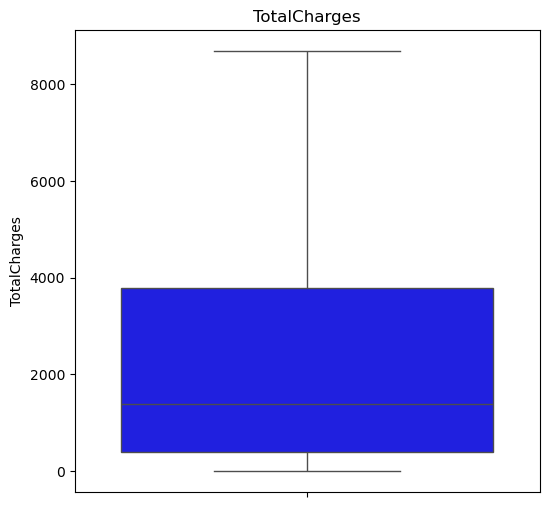

In [12]:
plt.figure(figsize = (6, 6))
plt.title("TotalCharges")
sns.boxplot(data = df['TotalCharges'], color = 'blue')
plt.show()

### Análise Univariada

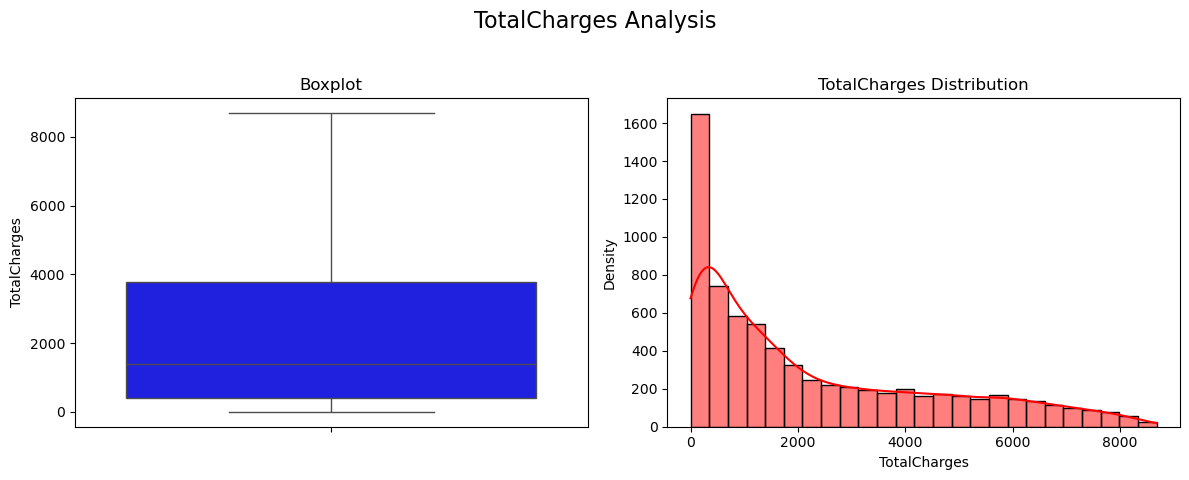

In [13]:
# Cria a figura e os eixos (subplots) para 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('TotalCharges Analysis', fontsize=16)
# Desenha o primeiro gráfico (Boxplot) no primeiro eixo (axes[0])
sns.boxplot(data=df['TotalCharges'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')
# Desenha o segundo gráfico (Histograma) no segundo eixo (axes[1])
sns.histplot(df['TotalCharges'], color='red', kde=True, ax=axes[1])
axes[1].set_title('TotalCharges Distribution')
axes[1].set_ylabel('Density')
# Ajusta o layout para evitar sobreposição e exibir o gráfico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

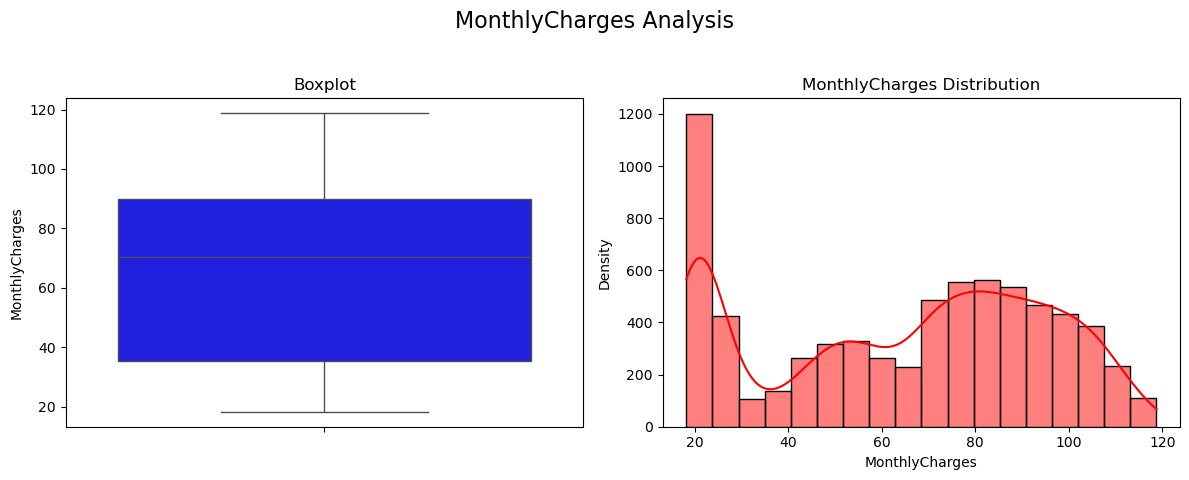

In [14]:
# Cria a figura e os eixos (subplots) para 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('MonthlyCharges Analysis', fontsize=16)
# Desenha o primeiro gráfico (Boxplot) no primeiro eixo (axes[0])
sns.boxplot(data=df['MonthlyCharges'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')
# Desenha o segundo gráfico (Histograma) no segundo eixo (axes[1])
sns.histplot(df['MonthlyCharges'], color='red', kde=True, ax=axes[1])
axes[1].set_title('MonthlyCharges Distribution')
axes[1].set_ylabel('Density')
# Ajusta o layout para evitar sobreposição e exibir o gráfico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

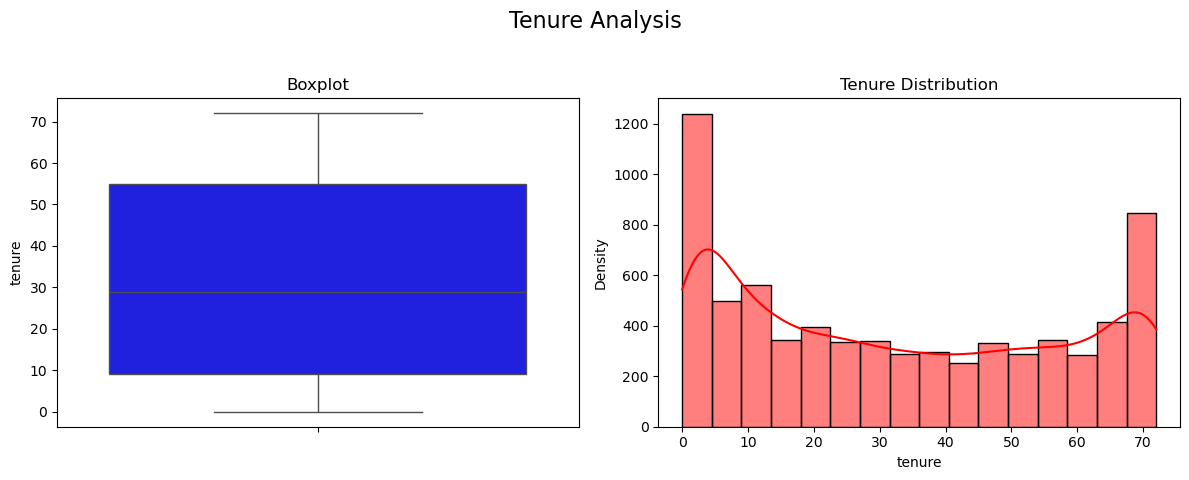

In [15]:
# Cria a figura e os eixos (subplots) para 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Tenure Analysis', fontsize=16)
# Desenha o primeiro gráfico (Boxplot) no primeiro eixo (axes[0])
sns.boxplot(data=df['tenure'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')
# Desenha o segundo gráfico (Histograma) no segundo eixo (axes[1])
sns.histplot(df['tenure'], color='red', kde=True, ax=axes[1])
axes[1].set_title('Tenure Distribution')
axes[1].set_ylabel('Density')
# Ajusta o layout para evitar sobreposição e exibir o gráfico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Vamos substituir os valores "No internet service" e "No phone service" por "No". Isso pois tem o mesmo siginficado (o cliente não tem esse serviço), e deixando em diferentes categorias iria criar mais informações sem adicionar relevância para o modelo.

In [16]:
# Lista de valores a serem substituídos
valores_substituir = ["No internet service", "No phone service"]

# Substituir por "No" em todas as colunas do DataFrame
df = df.replace(valores_substituir, "No")


Global Mean Churn Rate: 0.27


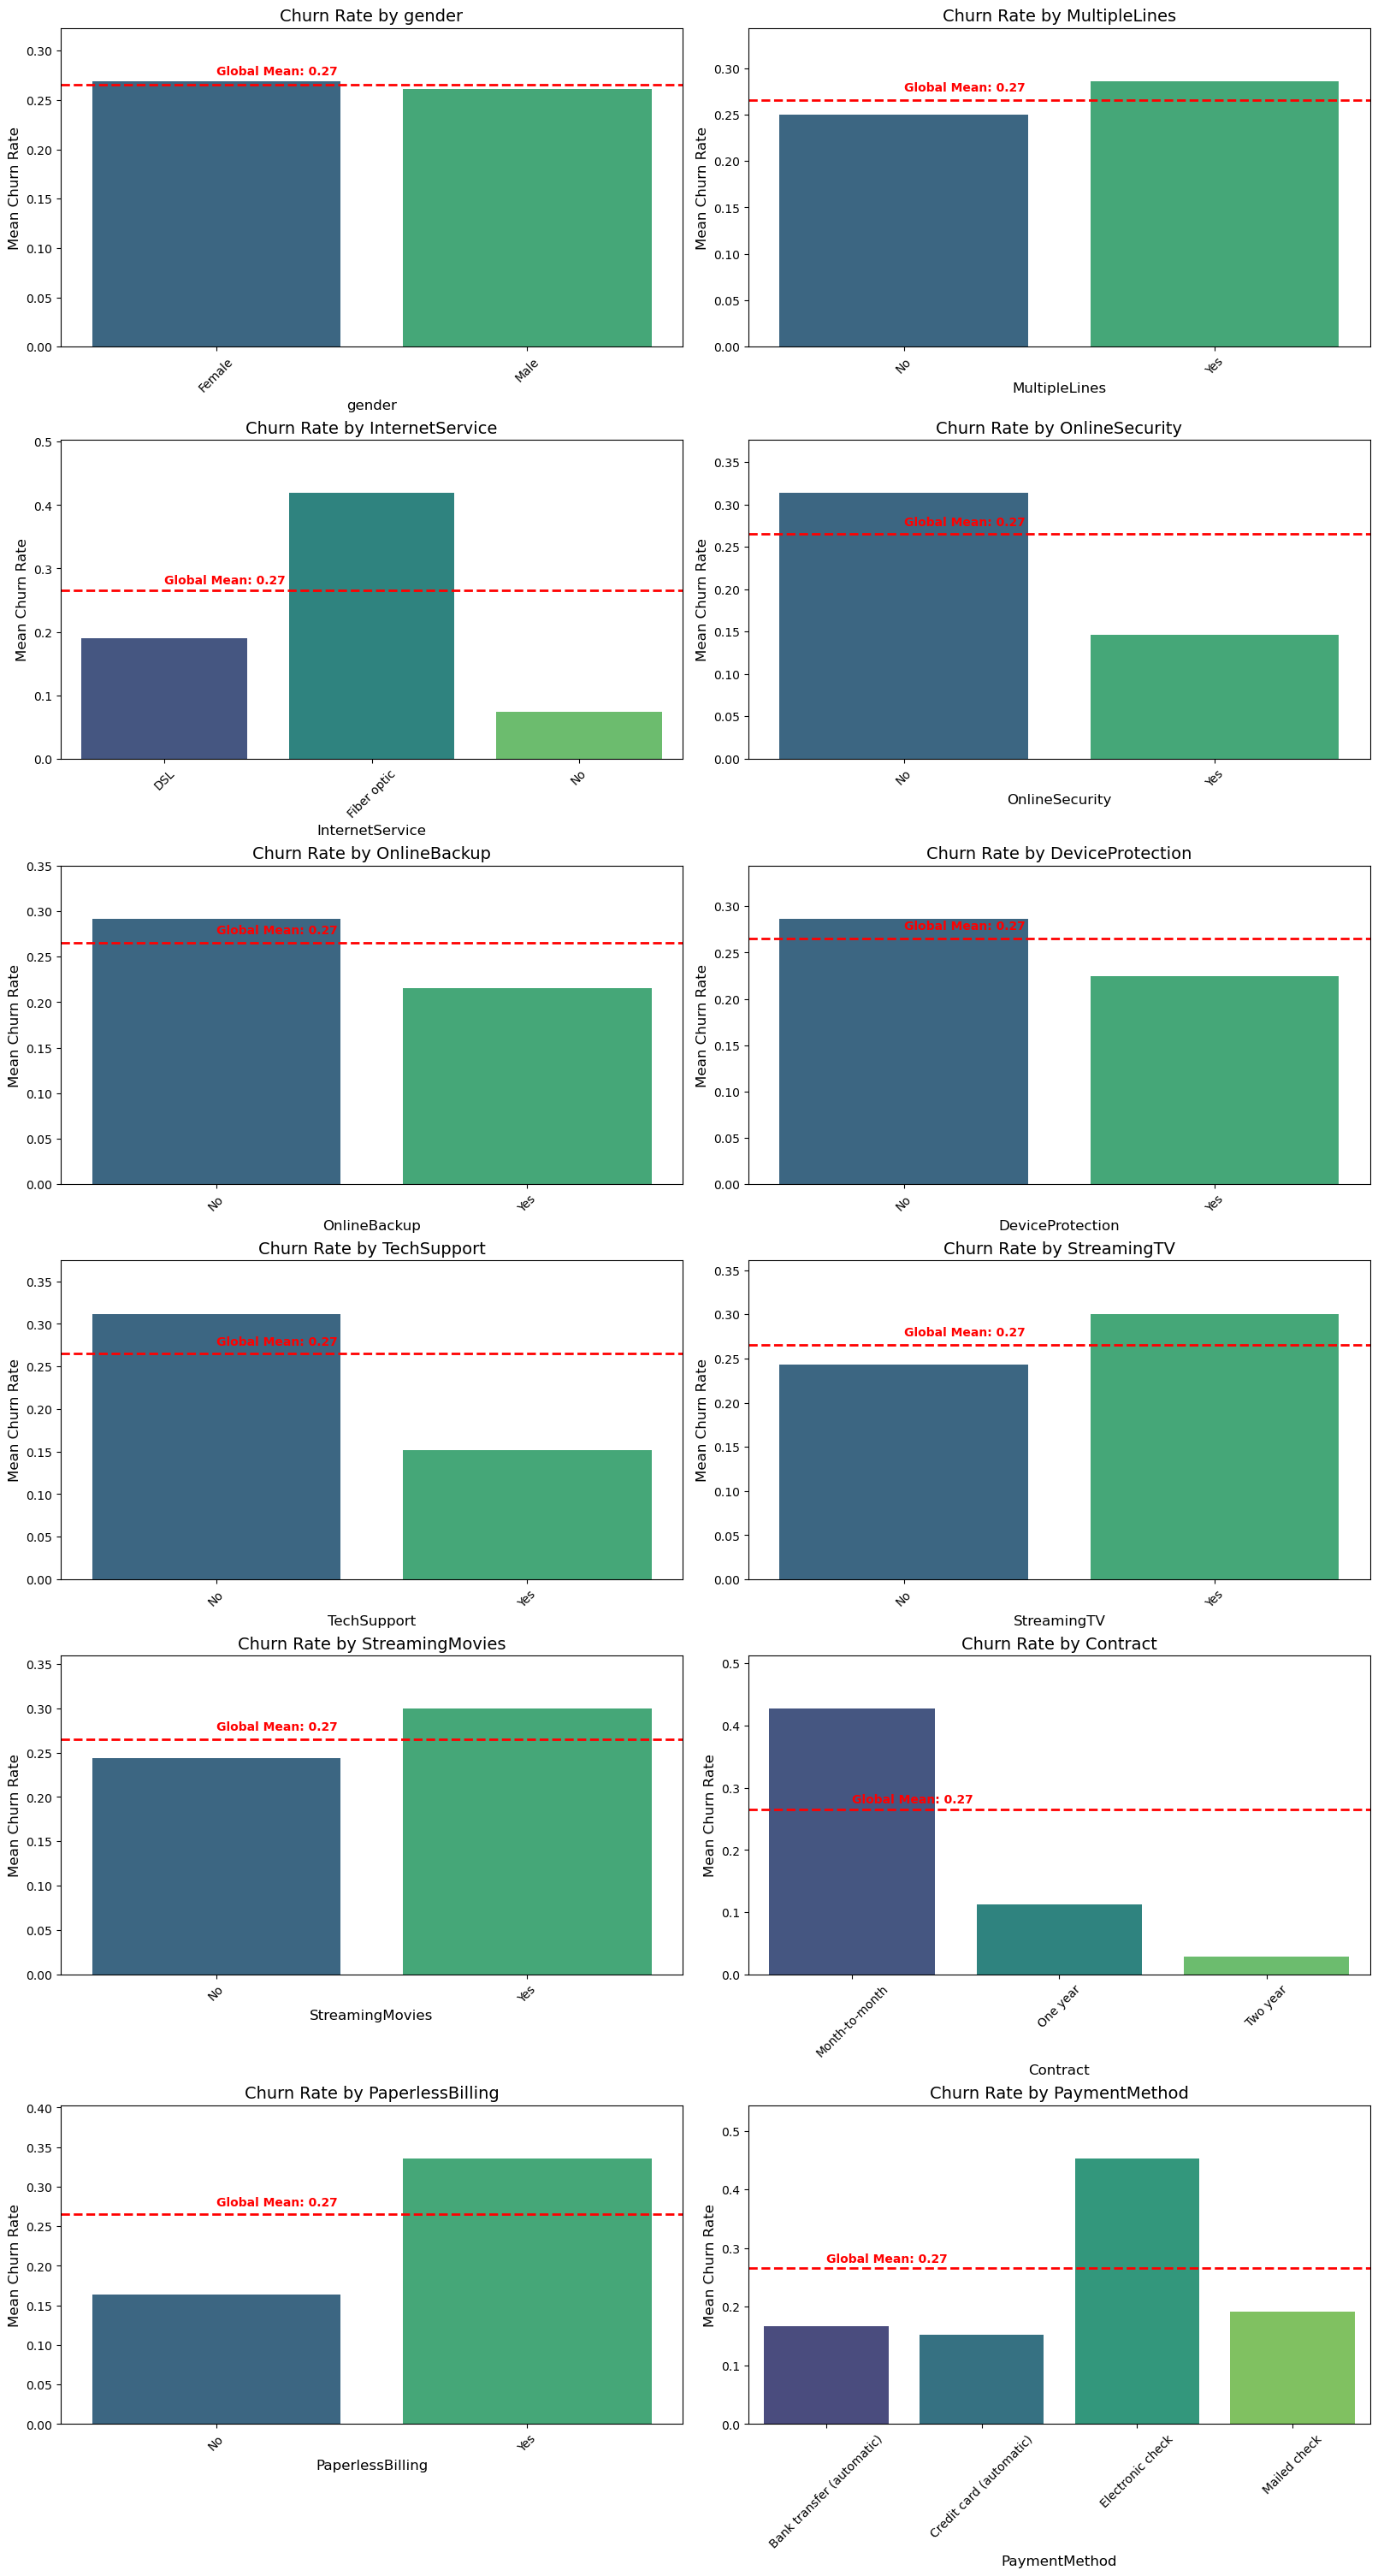

In [17]:
# 1. Cria uma cópia do DataFrame para não alterar o original
df_copy = df.copy()

# Converte a coluna 'Churn' para formato numérico (0 e 1)
df_copy['Churn'] = df_copy['Churn'].map({'No': 0, 'Yes': 1})

# 2. Define a lista de colunas categóricas para analisar
categorical_features = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# 3. Calcula a média global de Churn
global_mean = df_copy['Churn'].mean()
print(f"Global Mean Churn Rate: {global_mean:.2f}")

# 4. Subplots: dois por linha
n_features = len(categorical_features)
ncols = 2
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 5), constrained_layout=True)
axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

for i, feature in enumerate(categorical_features):
    # Agrupa por categoria e calcula a média de Churn para cada uma
    df_group = df_copy.groupby(by=feature)['Churn'].agg(['mean']).reset_index()

    # Seleciona o eixo do subplot correspondente
    ax = axes[i]

    # Cria o gráfico de barras
    graph = sns.barplot(x=feature, y='mean', data=df_group, palette='viridis', ax=ax)

    # Adiciona a linha da média global
    ax.axhline(global_mean, linewidth=2, color='red', linestyle='--')

    # Adiciona texto para identificar a linha da média global
    ax.text(0, global_mean + 0.01, f"Global Mean: {global_mean:.2f}", color='red', weight='semibold')

    # Adiciona títulos e rótulos (em inglês, como solicitado anteriormente)
    ax.set_title(f"Churn Rate by {feature}", fontsize=14)
    ax.set_ylabel("Mean Churn Rate", fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylim(0, max(df_group['mean'].max() * 1.2, global_mean * 1.2))  # Ajusta o limite do eixo Y
    ax.tick_params(axis='x', labelrotation=45)

# Esconde subplots não utilizados (se houver)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


## Insights

A taxa média de churn encontrada no conjunto é de aproximadamente **27%**, ou seja, cerca de um em cada quatro clientes encerra o contrato. Esse valor não é desprezível e deve ser tratado como um indicador crítico de retenção. Ao observar a variável `tenure`, nota-se uma mediana de 29 meses, mas com 25% dos clientes permanecendo nove meses ou menos, revelando uma forte concentração de clientes de curta duração e sugerindo churn precoce como risco principal.  

Em relação às cobranças, a variável `MonthlyCharges` apresenta média em torno de 64,8, mas com ampla dispersão, indicando perfis de consumo bastante distintos. Já `TotalCharges`, após a conversão para numérico e a imputação de nulos, mostra distribuição assimétrica e presença de outliers, o que reflete tanto a variação de tempo de contrato quanto o acúmulo de gastos ao longo do tempo. Por fim, a análise das variáveis categóricas, representadas por gráficos de barras com linha de referência da média global de churn, permite visualizar claramente quais segmentos se encontram acima ou abaixo da taxa média, tornando mais intuitiva a identificação de grupos prioritários para retenção.


### Análise Bivariada

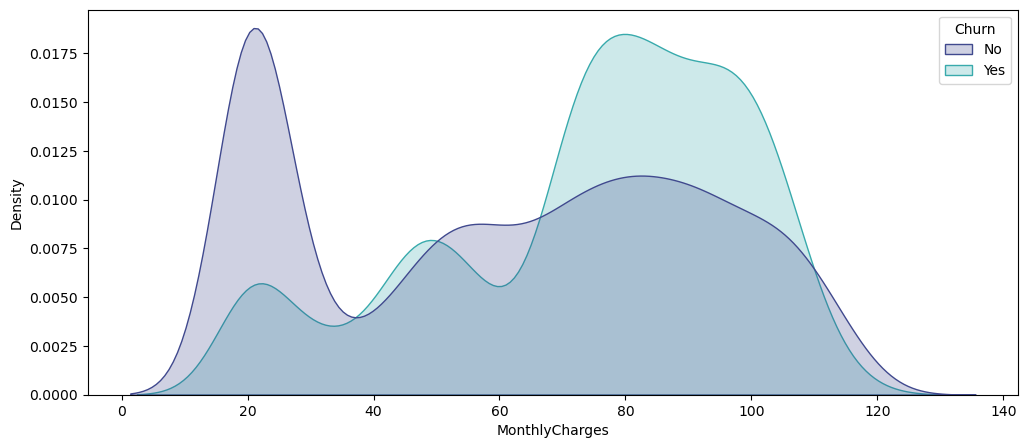

In [18]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

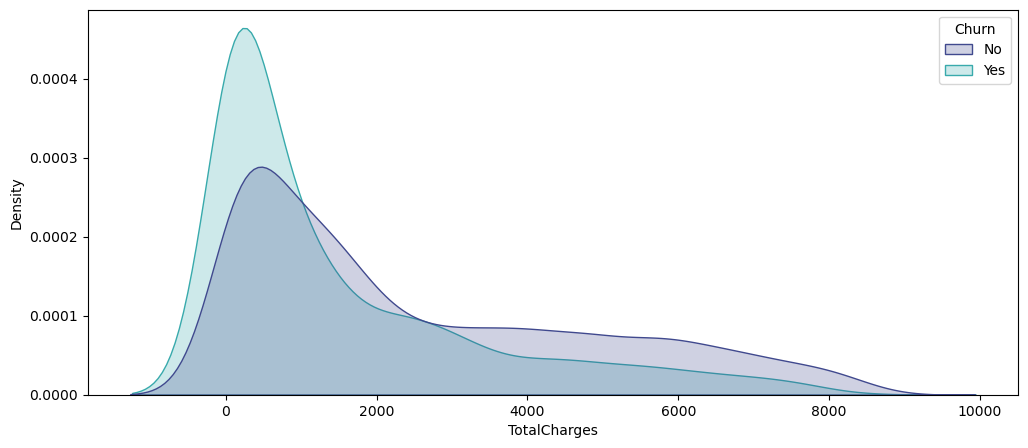

In [19]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

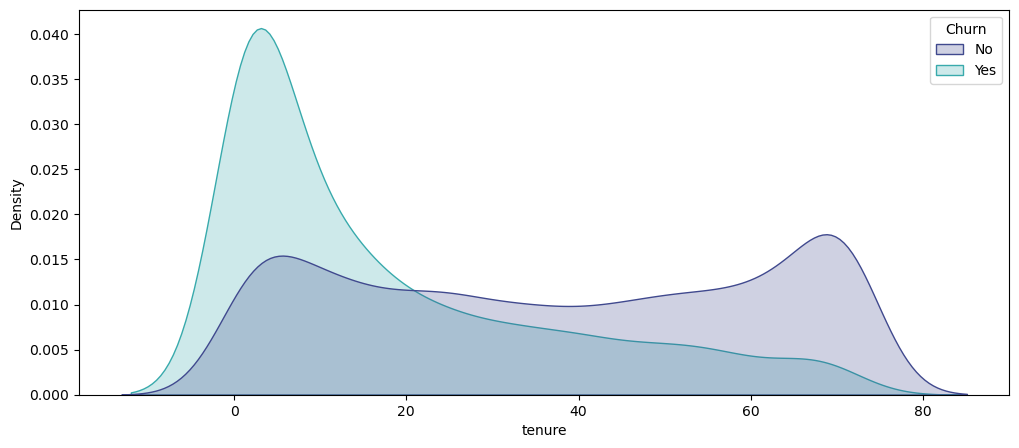

In [20]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

## Insights

A relação entre churn e `tenure` revela que clientes que cancelam tendem a estar concentrados nos primeiros meses de contrato, reforçando a necessidade de estratégias específicas de onboarding e fidelização já nos primeiros ciclos. A comparação entre churn e `MonthlyCharges` indica que existem faixas de cobrança em que a propensão ao cancelamento é maior, principalmente entre clientes com valores de fatura mais elevados, o que sugere a necessidade de avaliar a percepção de custo-benefício nesse segmento.  

Além disso, ao observar as variáveis categóricas, destaca-se que clientes em **contratos mês a mês**, aqueles que utilizam **pagamento eletrônico (`PaperlessBilling`)** e determinados **métodos de pagamento** apresentam taxas de churn superiores à média global. Esses perfis, portanto, constituem alvos estratégicos para intervenções direcionadas. Vale ressaltar também que o tratamento aplicado em `TotalCharges` foi essencial para evitar distorções e garantir consistência nas comparações realizadas.  



## Pré Processamento Dos Dados

In [21]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2237,2212-LYASK,Male,0,Yes,Yes,27,No,No,DSL,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),45.85,1246.40,No
6364,9717-IOAAF,Male,0,No,Yes,27,Yes,Yes,No,No,...,No,No,No,No,Two year,Yes,Credit card (automatic),25.85,788.55,No
6697,8080-POTJR,Female,0,No,No,30,Yes,Yes,DSL,Yes,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2427.10,No
6639,4816-OKWNX,Male,0,Yes,Yes,50,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),103.40,5236.40,No
2992,4177-JPDFU,Male,0,No,No,12,No,No,DSL,No,...,No,Yes,No,No,Month-to-month,No,Mailed check,34.00,442.45,No


In [22]:
# Removendo a coluna custumerID pois não tem valor preditivo
df = df.drop('customerID', axis=1) 

In [23]:
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5981,Female,0,Yes,Yes,38,Yes,No,No,No,No,No,No,No,No,Two year,Yes,Mailed check,20.20,746.05,No
1831,Female,1,Yes,No,22,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,Yes,Mailed check,63.55,1381.80,No
5535,Female,0,Yes,Yes,55,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),85.10,4657.95,No
306,Male,1,Yes,No,32,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.90,2303.35,Yes
6040,Female,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.75,70.75,Yes


In [24]:
df.describe(include=['object', 'bool'])

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,4072,3096,5024,4614,4621,4999,4336,4311,3875,4171,2365,5174


In [25]:
# ------------------------
# 1. Label Encoding nas variáveis binárias
# ------------------------
binarias = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'
]

# Mapear Yes/No para 1/0 e Male/Female para 1/0
mapeamento = {
    'Yes': 1,
    'No': 0,
    'Male': 1,
    'Female': 0
}

for col in binarias:
    df[col] = df[col].map(mapeamento)

In [26]:
# ------------------------
# 2. One-Hot Encoding nas variáveis nominais
# ------------------------
nominais = ['InternetService', 'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=nominais, drop_first=True, dtype=int)

In [27]:
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3958,1,0,1,0,16,1,1,0,0,0,...,73.85,1284.20,1,1,0,0,0,0,0,0
1006,0,0,0,0,18,1,1,0,0,0,...,90.10,1612.75,1,1,0,0,0,0,1,0
6360,0,0,0,0,1,1,0,0,0,0,...,20.30,20.30,1,0,1,0,0,0,0,1
5061,0,1,1,1,55,1,1,1,0,1,...,76.25,4154.55,0,0,0,1,0,0,1,0
6688,0,0,1,1,12,1,0,0,0,0,...,20.30,224.50,0,0,1,0,1,0,0,0


<Axes: >

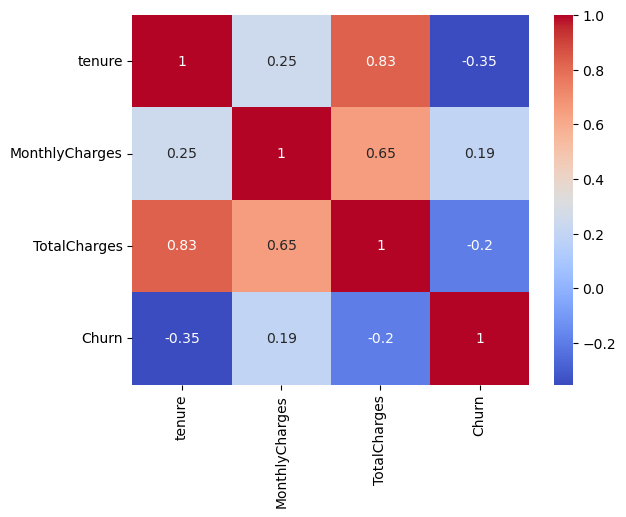

In [28]:
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr(), annot=True, cmap='coolwarm')

In [29]:
corr_matrix = df.corr()

# Selecionar apenas a correlação com a coluna 'Churn'
corr_churn = corr_matrix['Churn'].sort_values(ascending=False)

# Mostrar correlações
print(corr_churn)

Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV                              0.063228
StreamingMovies                          0.061382
MultipleLines                            0.040102
PhoneService                             0.011942
gender                                  -0.008612
DeviceProtection                        -0.066160
OnlineBackup                            -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport                             -0.164674
OnlineSecurity                          -0.171226
Contract_One year                       -0.177820


In [30]:
# Matriz de correlação
corr_matrix = df.corr()

# Definir limite para destacar correlações fortes
limite = 0.7

# Selecionar pares de variáveis altamente correlacionadas
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']

# Filtrar correlações acima do limite
corr_high = corr_pairs[abs(corr_pairs['Correlation']) > limite].sort_values(
    by='Correlation', ascending=False
)

print("Variáveis com altamente correlacionadas (|correlação| > 0.7):")
print(corr_high)

# Criar matriz filtrada: manter apenas correlações acima do limite (em módulo)
corr_filtrada = corr_matrix.mask(abs(corr_matrix) <= limite)

Variáveis com altamente correlacionadas (|correlação| > 0.7):
               Var1                         Var2  Correlation
96           tenure                 TotalCharges     0.826178
233  MonthlyCharges  InternetService_Fiber optic     0.787066
234  MonthlyCharges           InternetService_No    -0.763557


A correlação de 0.826 entre tenure e TotalCharges é extremamente alta, indicando uma forte multicolinearidade. TotalCharges é fundamentalmente o produto de tenure e MonthlyCharges (ou, mais precisamente, a soma dos MonthlyCharges ao longo do tenure). Manter as três variáveis juntas adiciona redundância e pode complicar a interpretabilidade, especialmente para modelos lineares, sem necessariamente adicionar mais poder preditivo.

Optamos por remover TotalCharges, e ainda sim retemos informações cruciais de tenure (tempo de permanência do cliente, um indicador chave de lealdade e maturidade na base) e MonthlyCharges (o custo atual do serviço, que se correlaciona com a qualidade/pacote de serviço e é um forte preditor de churn). Essas duas variáveis juntas já capturam a essência do que TotalCharges representa.

As demais correlações fortes refletem a relação intrínseca e de negócio entre o valor do serviço (MonthlyCharges) e o tipo de serviço (InternetService). Remover uma dessas variáveis significaria perder informações valiosas sobre o pacote de serviços do cliente, que é um preditor fortíssimo de churn. O modelo de Machine Learning pode e deve usar essas informações para aprender a relação. A multicolinearidade aqui é mais um reflexo de que uma variável (MonthlyCharges) é fortemente influenciada por outra (InternetService), e ambas são relevantes.

In [31]:
# Removendo a coluna custumerID pois não tem valor preditivo
df = df.drop('TotalCharges', axis=1) 

Contagem de Churn:
Churn
0    5174
1    1869
Name: count, dtype: int64


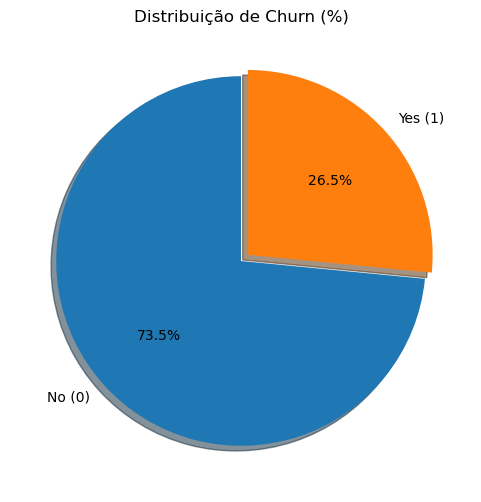

In [32]:
# Contagem de cada valor da variável alvo
churn_counts = df['Churn'].value_counts()

print("Contagem de Churn:")
print(churn_counts)

# Gráfico de pizza com percentuais dentro
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts, 
    labels=['No (0)', 'Yes (1)'],   
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#1f77b4', '#ff7f0e'],  # azul e laranja padrão
    explode=(0,0.05),
    shadow=True
)
plt.title("Distribuição de Churn (%)")
plt.show()


Temos um problema de desbalancemaneto de classe na variável alvo, para isso testaremos diferentes estratégias e abordagens e comparar qual nos dará o melhor modelo. NOsso objetivo é construir um modelo com acurácia acima de 95%

1. Separação de Features (X) e Variável Target (y)
Objetivo: Isolar a variável que queremos prever (Churn) das variáveis preditoras (todas as outras).

Justificativa: É a base para qualquer processo de aprendizado supervisionado. X será a matriz de entrada do nosso modelo, e y será a saída esperada durante o treinamento.

In [33]:
X = df.drop('Churn', axis=1) # Todas as colunas exceto 'Churn'
y = df['Churn']             # A coluna 'Churn'

2. Divisão dos Dados em Treino e Teste
Objetivo: Criar conjuntos de dados independentes para treinar o modelo (X_train, y_train) e para avaliar seu desempenho em dados nunca antes vistos (X_test, y_test).

Justificativa: Previne o overfitting (quando o modelo "decore" os dados de treino e não generalize bem para novos dados) e fornece uma estimativa mais realista do desempenho do modelo em produção.

Parâmetros Importantes:

test_size: Proporção do dataset a ser usada para o conjunto de teste (ex: 0.2 para 20%).
random_state: Garante que a divisão seja a mesma em execuções consecutivas, tornando seus resultados reprodutíveis.
stratify=y: Crucial para lidar com o desbalanceamento! Garante que a proporção das classes de Churn seja mantida tanto no conjunto de treino quanto no de teste. Sem isso, você poderia ter um conjunto de teste com pouquíssimas instâncias de churn, o que dificultaria a avaliação precisa do modelo na classe minoritária.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de X_test: {X_test.shape}")
print(f"Dimensões de y_train: {y_train.shape}")
print(f"Dimensões de y_test: {y_test.shape}")

# Verificar a proporção de Churn nos conjuntos
print("\nProporção de Churn em y_train:")
print(y_train.value_counts(normalize=True))
print("\nProporção de Churn em y_test:")
print(y_test.value_counts(normalize=True))


Dimensões de X_train: (5634, 22)
Dimensões de X_test: (1409, 22)
Dimensões de y_train: (5634,)
Dimensões de y_test: (1409,)

Proporção de Churn em y_train:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Proporção de Churn em y_test:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


3. Escalonamento das Variáveis Numéricas
Objetivo: Colocar as variáveis numéricas (tenure, MonthlyCharges) na mesma escala.

Justificativa:

Como as variáveis numéricas possuem escalas e distribuições diferentes, algoritmos baseados em distância (como KNN, SVM, Regressão Logística, Redes Neurais) são sensíveis a essa diferença. Uma feature com valores maiores pode ter um impacto desproporcional na função de custo do algoritmo.
O escalonamento ajuda esses algoritmos a convergir mais rapidamente e a encontrar soluções melhores.
Importante: Este passo deve ser feito APENAS nas variáveis numéricas. As variáveis categóricas (que agora são 0/1 ou outros inteiros após a codificação) não precisam ser escalonadas com StandardScaler ou MinMaxScaler.

Qual Scaler Usar?

StandardScaler: (Média 0, Desvio Padrão 1) É robusto para a maioria dos casos e é a escolha comum quando a distribuição dos dados não é normal ou possui outliers (embora outliers extremos ainda possam influenciar a média e o desvio padrão).
MinMaxScaler: (Escala para um range, geralmente 0-1) Útil quando você precisa que os dados estejam em um range fixo, como para redes neurais com funções de ativação específicas.

Para este projeto, StandardScaler é uma ótima escolha.

Ordem Correta do Escalonamento (para evitar Data Leakage):

fit() APENAS no X_train: O StandardScaler (ou qualquer outro scaler) deve "aprender" a média e o desvio padrão somente a partir dos dados de treinamento. Isso simula uma situação real onde o modelo só tem acesso aos dados de treino.
transform() em X_train e X_test: Aplique a transformação (usando a média e o desvio padrão aprendidos no X_train) tanto no conjunto de treinamento quanto no conjunto de teste. Nunca faça fit_transform() no X_test, pois isso causaria data leakage.

EPLICAÇÃO MAIS DETALHADA:

### O Que é Data Leakage (Vazamento de Dados)?

Em Machine Learning, "data leakage" acontece quando a informação do conjunto de testes (ou, de forma mais geral, informação que não estaria disponível no momento em que o modelo faz uma previsão no mundo real) "vaza" para o conjunto de treinamento, influenciando o processo de aprendizado do modelo.

O resultado? Seu modelo parecerá ter um desempenho excelente durante o desenvolvimento e teste (métricas inflacionadas), mas falhará miseravelmente quando for colocado em produção e encontrar dados verdadeiramente "novos" e "não vistos".

### A Analogia do Estudante e o Exame (a mais comum e eficaz)

Imagine que você é um professor preparando seus alunos para um exame final.

1.  **Conjunto de Treinamento (`X_train` e `y_train`):** É todo o material de estudo que você fornece aos alunos: livros, apostilas, exercícios resolvidos em sala, listas de problemas para praticar em casa. É com base nesse material que os alunos devem aprender e se preparar.

2.  **Conjunto de Teste (`X_test` e `y_test`):** É o próprio exame final. Ele contém perguntas que os alunos *nunca viram antes*. O objetivo do exame é avaliar se os alunos realmente aprenderam os conceitos do material de estudo e conseguem aplicá-los a novos problemas, e não apenas "decoraram" as respostas de exercícios específicos.

#### Como o `StandardScaler` Entra Nisso?

O `StandardScaler` precisa calcular a **média** e o **desvio padrão** das suas colunas numéricas para poder "escalar" os dados. Pense na média e no desvio padrão como as "características" ou "regras de normalização" desses dados.

*   **`scaler.fit(X_train)`:**
    *   **Analogia:** É como o professor analisando *apenas o material de estudo* (`X_train`) para entender a dificuldade geral dos problemas, a variação das notas, o tempo médio para resolver certas questões, etc. Com base *nesse material*, o professor cria as "regras" ou "parâmetros" para a prova e decide como vai "normalizar" a nota de cada aluno (por exemplo, "se a média dos exercícios foi 7, e o desvio padrão foi 1.5, então uma nota 8 é considerada acima da média em X pontos").
    *   **O que acontece:** O `StandardScaler` calcula a média e o desvio padrão para cada coluna numérica **usando apenas os dados de treinamento (`X_train`)**.

*   **`scaler.transform(X_train)`:**
    *   **Analogia:** É como os alunos usando as "regras de normalização" (média e desvio padrão calculadas) para praticar com o material de estudo. Eles transformam seus resultados de prática com base no que aprenderam *apenas do material de estudo*.
    *   **O que acontece:** O `StandardScaler` aplica a transformação nas colunas numéricas do `X_train`, usando a média e o desvio padrão que ele *aprendeu* no passo anterior.

*   **`scaler.transform(X_test)` (O Ponto Chave!)**
    *   **Analogia:** Chegou o dia do exame. Os alunos fazem o exame (`X_test`) e, ao final, o professor aplica as *mesmas "regras de normalização" que foram definidas com base no material de estudo* (`X_train`) para transformar as notas do exame.
    *   **O que acontece:** O `StandardScaler` aplica a transformação nas colunas numéricas do `X_test`, usando a **mesma média e desvio padrão** que ele aprendeu no `X_train`.

#### O Perigo: `scaler.fit_transform(X_test)` ou `scaler.fit(X)` (usando o DataFrame completo antes da divisão)

Agora, e se você fizesse `scaler.fit_transform(X_test)` ou `scaler.fit(X)` antes de dividir os dados?

*   **Analogia:** Seria como o professor, ao definir as "regras de normalização" ou os "parâmetros" do exame, analisasse **tanto o material de estudo QUANTO o próprio exame final** (`X_test`).
    *   Ou pior, o professor olha para as perguntas do exame final, para a média que os alunos *tiraram no próprio exame* e o desvio padrão *das notas do próprio exame* para decidir como "normalizar" essas notas.
    *   Isso seria **trapacear**! O professor estaria usando informações do desempenho no exame (que é supostamente "novo" e "não visto") para influenciar como ele avalia o aprendizado dos alunos. As "regras" de normalização estariam contaminadas com o conhecimento das próprias perguntas do exame.

*   **Consequência:**
    *   **Viés Otimista:** As notas do exame (`X_test`) pareceriam artificialmente melhores. Seu modelo teria uma acurácia e outras métricas excelentes no conjunto de teste, porque ele "sabia" (indiretamente, através das estatísticas do scaler) algo sobre os dados de teste *antes* de ser avaliado.
    *   **Falha no Mundo Real:** Quando seu modelo for para a "vida real" e encontrar dados verdadeiramente novos (que o scaler nunca "viu" para calcular suas estatísticas), ele não terá essa "vantagem" de conhecimento prévio e seu desempenho será drasticamente pior do que o esperado.

### Resumo e a Receita Correta:

Para evitar o vazamento de dados durante o pré-processamento (escalonamento, imputação, etc.):

1.  **Divida os dados em treino e teste PRIMEIRO.**
2.  **Calcule os parâmetros de pré-processamento (e.g., média/desvio padrão do `StandardScaler`) APENAS no conjunto de TREINO.** (Isso é o `fit()`).
3.  **Aplique esses parâmetros calculados (do treino) tanto no conjunto de TREINO quanto no conjunto de TESTE.** (Isso é o `transform()`).

Essa prática garante que o seu modelo só aprenda com informações que estariam disponíveis para ele em um cenário real de previsão, resultando em uma avaliação de desempenho muito mais honesta e confiável.

In [35]:
# Identificar as colunas numéricas
numeric_cols = ['tenure', 'MonthlyCharges'] # Lembre-se que TotalCharges foi removido

# Inicializar o StandardScaler
scaler = StandardScaler()

# Ajustar o scaler aos dados de treino e transformar os dados de treino
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transformar os dados de teste usando o scaler JÁ AJUSTADO nos dados de treino
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Opcional: Verifique as estatísticas de X_train para confirmar o escalonamento
print("\nEstatísticas de X_train após escalonamento (colunas numéricas):")
print(X_train[numeric_cols].describe())


Estatísticas de X_train após escalonamento (colunas numéricas):
             tenure  MonthlyCharges
count  5.634000e+03    5.634000e+03
mean  -1.008935e-17   -2.402527e-16
std    1.000089e+00    1.000089e+00
min   -1.322329e+00   -1.544028e+00
25%   -9.559779e-01   -9.711977e-01
50%   -1.418632e-01    1.848336e-01
75%    9.164859e-01    8.319124e-01
max    1.608483e+00    1.785939e+00


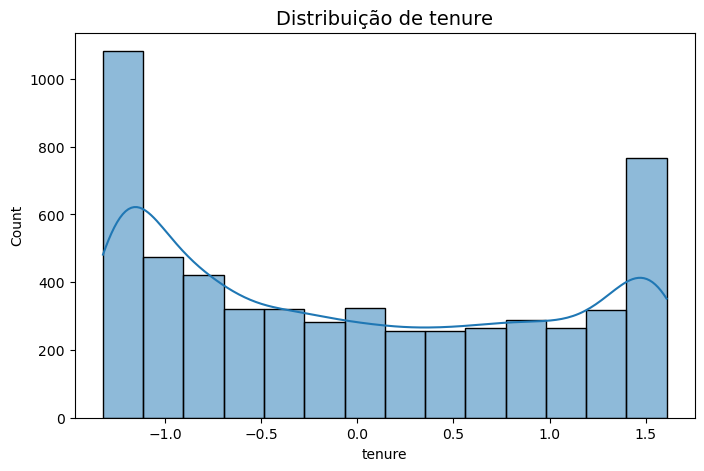

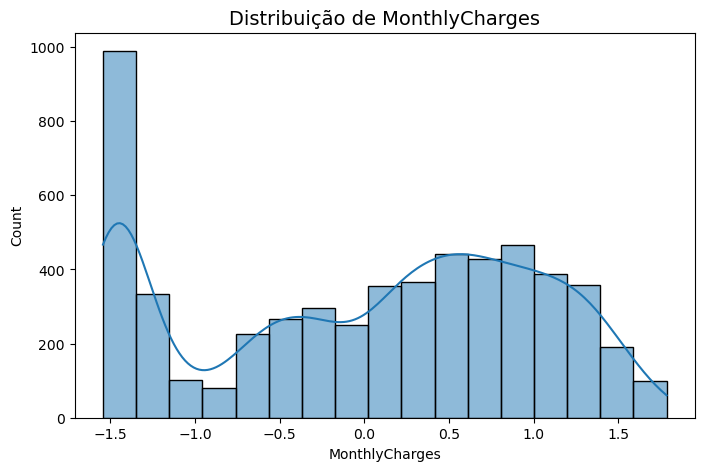

In [36]:
numeric_cols = ["tenure", 'MonthlyCharges']

for feat in numeric_cols:
    # 1. Cria uma nova figura para cada gráfico
    plt.figure(figsize=(8, 5)) 
    
    # 2. Usa histplot com a curva de densidade (kde=True)
    sns.histplot(data=X_train, x=feat, kde=True)
    
    # 3. Adiciona um título e exibe o gráfico
    plt.title(f'Distribuição de {feat}', fontsize=14)
    plt.show()

## Criação e Avaliação dos Modelos de Machine Learning

### Regressão Logística

Modelo 1: Regressão Logística
A Regressão Logística é um modelo de classificação linear que estima a probabilidade de uma instância pertencer a uma determinada classe.

Parâmetro class_weight='balanced': Este parâmetro ajusta automaticamente os pesos das classes de forma inversamente proporcional à sua frequência nos dados de treinamento. Isso significa que ele dará maior importância aos erros de classificação da classe minoritária (Churn), ajudando o modelo a aprender melhor sobre ela.

In [54]:
print("--- Treinando e Avaliando o Modelo de Regressão Logística ---")

# Inicializar o modelo de Regressão Logística com class_weight='balanced'
# solver='liblinear' é um bom default para datasets pequenos e médios, e lida bem com L1/L2
# max_iter aumenta o número máximo de iterações para garantir a convergência
log_reg_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)

# Treinar o modelo
log_reg_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

--- Treinando e Avaliando o Modelo de Regressão Logística ---



--- Relatório de Classificação (Regressão Logística ---
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409


--- Matriz de Confusão (Regressão Logística) ---


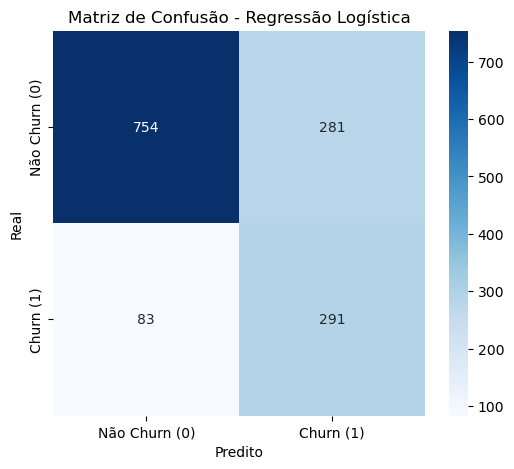

In [55]:
print("\n--- Relatório de Classificação (Regressão Logística ---")
print(classification_report(y_test, y_pred_log_reg))

print("\n--- Matriz de Confusão (Regressão Logística) ---")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

Perfeito, Gabriel, agora dá para interpretar essa matriz de confusão específica do seu modelo de **Regressão Logística**. Vamos destrinchar 👇

---

### 📊 Matriz de Confusão

* **TN (Não churn predito corretamente):** **754**
* **FP (Predito churn, mas era não churn):** **281**
* **FN (Predito não churn, mas era churn):** **83**
* **TP (Churn predito corretamente):** **291**

---

### 📐 Métricas principais

1. **Acurácia**

$$
\frac{TP + TN}{TP + TN + FP + FN} = \frac{754 + 291}{754 + 281 + 83 + 291} = \frac{1045}{1409} \approx 74.2\%
$$

👉 O modelo acerta cerca de **74% das previsões totais**.

---

2. **Precisão (para classe churn = 1)**

$$
\frac{TP}{TP + FP} = \frac{291}{291 + 281} = \frac{291}{572} \approx 50.9\%
$$

👉 Entre os que o modelo disse que **iriam cancelar**, só **metade realmente cancela**.
⚠️ Muitos **falsos positivos**.

---

3. **Recall (Sensibilidade para churn = 1)**

$$
\frac{TP}{TP + FN} = \frac{291}{291 + 83} = \frac{291}{374} \approx 77.8\%
$$

👉 O modelo consegue identificar **\~78% dos clientes que realmente cancelam**.
✅ Bom poder de detecção.

---

4. **Especificidade (para não churn = 0)**

$$
\frac{TN}{TN + FP} = \frac{754}{754 + 281} = \frac{754}{1035} \approx 72.9\%
$$

👉 Ele acerta **73% dos clientes que não cancelam**, mas ainda confunde muitos como churn.

---

5. **F1-Score (equilíbrio entre precisão e recall do churn)**

$$
F1 = \frac{2 \cdot (0.509 \cdot 0.778)}{0.509 + 0.778} \approx 61.7\%
$$

👉 O modelo tem um **equilíbrio moderado** entre detectar churn e não gerar tanto alarme falso.

---

### 🧠 Interpretação prática

* O modelo **identifica bem os clientes que vão cancelar (bom recall: 78%)**, o que é ótimo para estratégias de retenção.
* Porém, **tem muitos falsos positivos (281)** → ou seja, ele indica que clientes fiéis vão cancelar, quando na verdade não. Isso pode gerar **custo extra** se a empresa investir ações de retenção em quem não iria sair.
* A **precisão de apenas 51%** mostra que o modelo “desconfia demais” de churn.

👉 Em termos de negócio:

* **Ponto positivo:** o modelo ajuda a não deixar escapar muitos clientes que realmente cancelariam.
* **Ponto negativo:** pode sobrecarregar a equipe de retenção, pois muitos clientes "alertados" não iriam cancelar.

---



AUC-ROC (Regressão Logística): 0.8389


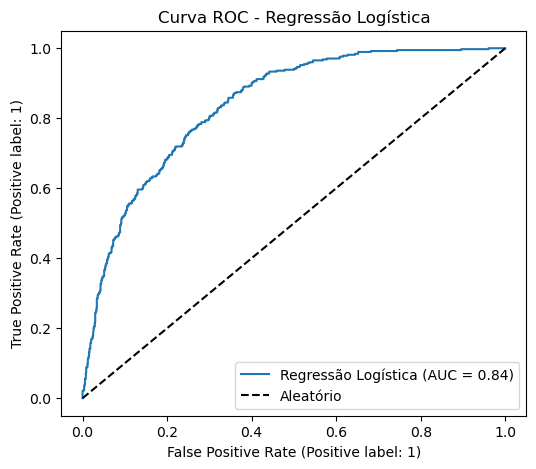

In [40]:
# Calcular e exibir AUC-ROC
auc_log_reg = roc_auc_score(y_test, y_proba_log_reg)
print(f"\nAUC-ROC (Regressão Logística): {auc_log_reg:.4f}")

# Plotar Curva ROC
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax, name='Regressão Logística')
plt.title('Curva ROC - Regressão Logística')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório') # Linha de base aleatória
plt.legend()
plt.show()


## 📊 O que é a Curva ROC?

* **ROC (Receiver Operating Characteristic)** mostra a relação entre:

  * **Taxa de Verdadeiros Positivos (TPR ou Recall)** no eixo **Y**
  * **Taxa de Falsos Positivos (FPR)** no eixo **X**

$$
TPR = \frac{TP}{TP + FN}, \quad FPR = \frac{FP}{FP + TN}
$$

* A linha **diagonal (preta tracejada)** representa um **classificador aleatório** (sem poder preditivo).
* Quanto mais a curva do modelo se afasta para o canto superior esquerdo (↑), melhor é a separação entre classes.

---

## 📐 Interpretação do seu gráfico

* O modelo tem **AUC = 0.8389 ≈ 0.84**.
* **AUC (Área sob a curva)** é a probabilidade de o modelo atribuir uma pontuação maior a um cliente que realmente vai cancelar do que a um cliente que não vai cancelar.
* Valores de referência para AUC:

  * **0.5** → modelo aleatório (sem utilidade).
  * **0.6 – 0.7** → fraco.
  * **0.7 – 0.8** → razoável/bom.
  * **0.8 – 0.9** → muito bom.
  * **> 0.9** → excelente.

👉 Seu modelo com **AUC = 0.84** está em um nível **muito bom**, indicando que a Regressão Logística consegue separar bem clientes churn vs não churn.

---

## 🧠 Relação com o negócio

* A curva mostra que o modelo tem **boa capacidade de discriminação**, ou seja, ele consegue diferenciar quem provavelmente vai cancelar de quem não vai.
* Isso é importante porque, na prática, você pode **ajustar o limiar de decisão**:

  * Se quiser **reduzir falsos negativos** (não deixar escapar clientes que realmente cancelam), pode baixar o threshold → aumenta recall, mas gera mais falsos positivos.
  * Se quiser **reduzir falsos positivos** (não incomodar clientes que não iriam cancelar), pode subir o threshold → aumenta precisão, mas pode deixar passar churns.

---

## 📌 Complementando com o que vimos na matriz de confusão

* A matriz mostrou que o modelo tem **bom recall (78%)**, mas **precisão baixa (51%)**.
* A curva ROC e o AUC confirmam que o modelo é **robusto na separação das classes**.
* O desafio é **ajustar o ponto de corte** (threshold, padrão 0.5) para encontrar o equilíbrio certo entre custo de retenção (FP) e risco de perder clientes (FN).

### Random Forest

Modelo 2: Random Forest Classifier
Random Forest é um algoritmo de aprendizado de máquina ensemble que constrói múltiplas árvores de decisão e combina suas previsões para obter um resultado mais preciso e estável.

Parâmetro class_weight='balanced': Assim como na Regressão Logística, este parâmetro instrui o algoritmo a atribuir maior peso às amostras da classe minoritária durante o treinamento de cada árvore, ajudando a mitigar o viés do desbalanceamento.

In [41]:
print("\n\n--- Treinando e Avaliando o Modelo Random Forest ---")

# Inicializar o modelo Random Forest com class_weight='balanced'
# n_estimators: número de árvores na floresta (pode ser ajustado)
# random_state: para reprodutibilidade
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)



--- Treinando e Avaliando o Modelo Random Forest ---



--- Relatório de Classificação (Random Forest) ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409


--- Matriz de Confusão (Random Forest) ---


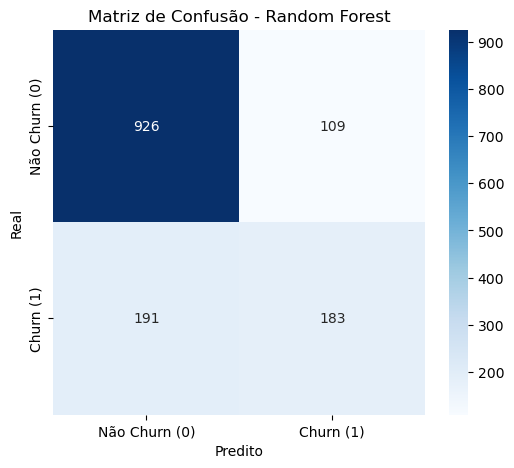

In [42]:
print("\n--- Relatório de Classificação (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Matriz de Confusão (Random Forest) ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Random Forest')
plt.show()



AUC-ROC (Random Forest): 0.8195


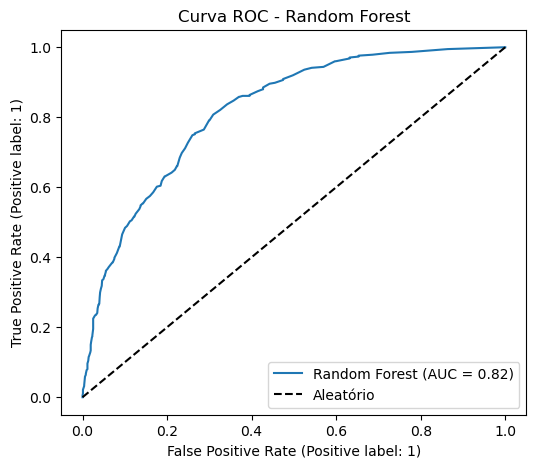

In [43]:
# Calcular e exibir AUC-ROC
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nAUC-ROC (Random Forest): {auc_rf:.4f}")

# Plotar Curva ROC
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, name='Random Forest')
plt.title('Curva ROC - Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório') # Linha de base aleatória
plt.legend()
plt.show()

### Utilizando Balanceamento de Classes

Entendendo SMOTE com Undersampling
Como discutimos, o desbalanceamento de classes pode levar a modelos que ignoram a classe minoritária. O parâmetro class_weight='balanced' nos modelos tenta mitigar isso ajustando os pesos, mas as técnicas de reamostragem modificam a distribuição dos dados de treinamento, fornecendo uma base mais "justa" para o modelo aprender.

1. SMOTE (Synthetic Minority Over-sampling Technique)
O que é? Em vez de simplesmente duplicar amostras existentes da classe minoritária (que pode levar a overfitting), o SMOTE cria novas amostras sintéticas.
Como funciona? Para cada amostra da classe minoritária, o SMOTE encontra seus vizinhos mais próximos (usando, por exemplo, k-NN). Em seguida, ele seleciona um ou mais desses vizinhos e cria uma nova amostra sintética em algum lugar ao longo da linha que conecta a amostra original e seu vizinho. Isso gera pontos "intermediários" que são semelhantes, mas não idênticos, às amostras originais.
Vantagens: Aumenta a representação da classe minoritária sem copiar as amostras existentes, o que ajuda o modelo a aprender padrões mais robustos para essa classe.
2. Undersampling (Subamostragem) da Classe Majoritária
O que é? Reduz o número de amostras da classe majoritária.
Como funciona? Existem várias técnicas, desde a remoção aleatória (Random Under-sampling) até métodos mais sofisticados que tentam remover amostras que são redundantes ou que não contribuem para a separação das classes.
Vantagens: Ajuda a equilibrar o dataset sem introduzir muitos novos pontos sintéticos.
Desvantagens: Pode levar à perda de informações importantes da classe majoritária se as amostras forem removidas indiscriminadamente.
3. Por Que Combinar SMOTE e Undersampling? (SMOTETomek ou SMOTEENN)
SMOTE, por si só, pode criar amostras sintéticas em regiões onde a classe majoritária também tem pontos. Isso pode levar a fronteiras de decisão menos claras e ao que é conhecido como "over-generalization" (generalização excessiva) ou ruído.

SMOTETomek: É uma combinação de SMOTE com a técnica de undersampling Tomek Links.

Tomek Links: Um par de amostras de classes diferentes forma um Tomek Link se elas são o vizinho mais próximo uma da outra. Em outras palavras, elas estão muito próximas da fronteira de decisão.
Como funciona SMOTETomek:
Primeiro, aplica SMOTE para gerar amostras sintéticas da classe minoritária.
Em seguida, identifica e remove os Tomek Links. Isso significa que ele remove:
Amostras da classe majoritária que são vizinhas muito próximas de amostras da classe minoritária (original ou sintética).
Amostras da classe minoritária que são vizinhas muito próximas de amostras da classe majoritária.
Vantagem: Ajuda a "limpar" a fronteira de decisão, removendo amostras da classe majoritária que estão muito perto da classe minoritária, e garantindo que os novos pontos sintéticos do SMOTE não sejam muito ambíguos. Isso geralmente leva a uma fronteira de decisão mais bem definida e, consequentemente, a um melhor desempenho do modelo.
SMOTEENN (SMOTE + Edited Nearest Neighbours): Outra combinação popular. Aplica SMOTE e depois usa ENN para limpar os dados. ENN remove uma amostra se a maioria dos seus k vizinhos mais próximos pertence a uma classe diferente da sua. Isso pode ser mais agressivo na remoção de ruído.

Para este caso, vamos usar SMOTETomek como uma excelente primeira tentativa combinada, pois visa criar uma fronteira de decisão mais clara.

Ponto Crucial: Ao utilizar técnicas de reamostragem como SMOTE, você NÃO DEVE mais usar o parâmetro class_weight='balanced' nos modelos. O dataset de treinamento já estará balanceado, e usar o class_weight novamente pode introduzir um novo viés ou comportamento indesejado.

### Aplicando SMOTE + Undersampling (SMOTETomek)

In [44]:
print("--- Aplicando SMOTETomek ao conjunto de treinamento ---")

# Inicializar SMOTETomek
# random_state para reprodutibilidade
smote_tomek = SMOTETomek(random_state=42)

# Aplicar SMOTETomek ao X_train e y_train
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("\nBalanceamento das classes após SMOTETomek:")
print(y_train_resampled.value_counts())

--- Aplicando SMOTETomek ao conjunto de treinamento ---

Balanceamento das classes após SMOTETomek:
Churn
0    3965
1    3965
Name: count, dtype: int64


Justificativa: Esta etapa transforma o X_train e y_train originais em X_train_resampled e y_train_resampled, que terão uma distribuição de classes mais equitativa. fit_resample calcula os parâmetros para a reamostragem e aplica a transformação.

3. Treinar os Modelos com o Conjunto de Treinamento Reamostrado
Agora, vamos treinar os mesmos modelos (Regressão Logística e Random Forest), mas usando os dados X_train_resampled e y_train_resampled, e sem o parâmetro class_weight='balanced'.

### Regressão Logística com SMOTETomek


--- Treinando e Avaliando o Modelo de Regressão Logística com SMOTETomek ---

--- Relatório de Classificação (Regressão Logística com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409


--- Matriz de Confusão (Regressão Logística com SMOTETomek) ---


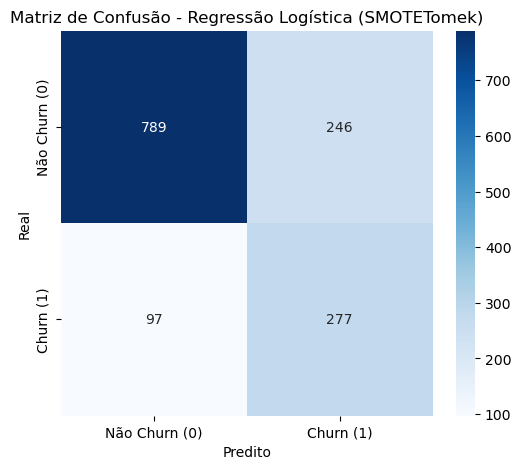


AUC-ROC (Regressão Logística com SMOTETomek): 0.8323


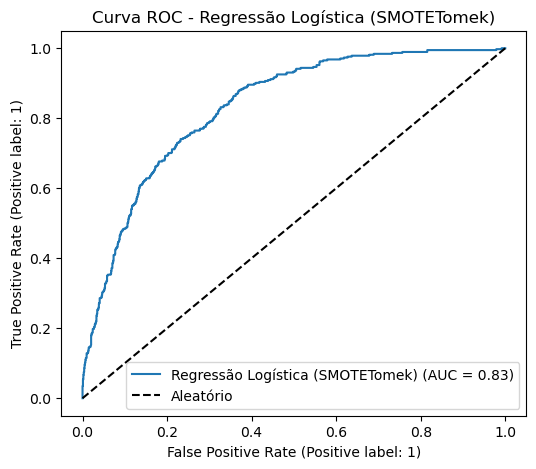

In [45]:
print("\n--- Treinando e Avaliando o Modelo de Regressão Logística com SMOTETomek ---")

# Regressão Logística
log_reg_smote_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # SEM class_weight='balanced'
log_reg_smote_model.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg_smote = log_reg_smote_model.predict(X_test)
y_proba_log_reg_smote = log_reg_smote_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (Regressão Logística com SMOTETomek) ---")
print(classification_report(y_test, y_pred_log_reg_smote))

print("\n--- Matriz de Confusão (Regressão Logística com SMOTETomek) ---")
cm_log_reg_smote = confusion_matrix(y_test, y_pred_log_reg_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Regressão Logística (SMOTETomek)')
plt.show()

auc_log_reg_smote = roc_auc_score(y_test, y_proba_log_reg_smote)
print(f"\nAUC-ROC (Regressão Logística com SMOTETomek): {auc_log_reg_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_smote_model, X_test, y_test, ax=ax, name='Regressão Logística (SMOTETomek)')
plt.title('Curva ROC - Regressão Logística (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()


AUC-ROC (Regressão Logística com SMOTETomek): 0.8323


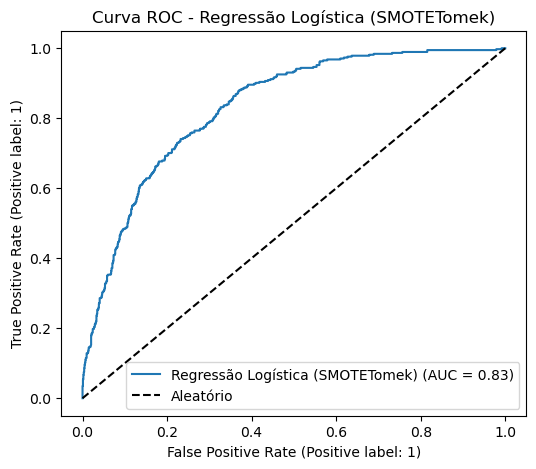

In [46]:
auc_log_reg_smote = roc_auc_score(y_test, y_proba_log_reg_smote)
print(f"\nAUC-ROC (Regressão Logística com SMOTETomek): {auc_log_reg_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_smote_model, X_test, y_test, ax=ax, name='Regressão Logística (SMOTETomek)')
plt.title('Curva ROC - Regressão Logística (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

### Random Forest com SMOTETomek



--- Treinando e Avaliando o Modelo Random Forest com SMOTETomek ---

--- Relatório de Classificação (Random Forest com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.55      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409


--- Matriz de Confusão (Random Forest com SMOTETomek) ---


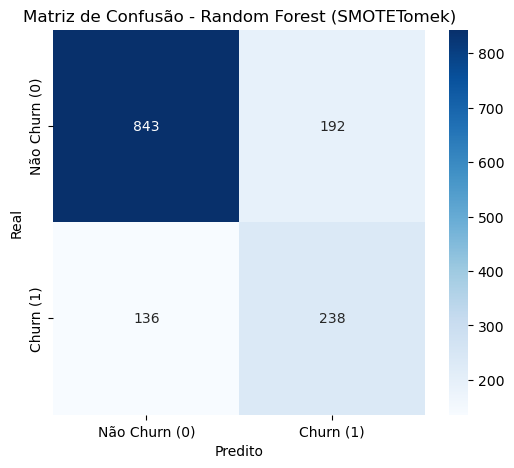

In [47]:
print("\n\n--- Treinando e Avaliando o Modelo Random Forest com SMOTETomek ---")

# Random Forest
rf_smote_model = RandomForestClassifier(random_state=42, n_estimators=100) # SEM class_weight='balanced'
rf_smote_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf_smote = rf_smote_model.predict(X_test)
y_proba_rf_smote = rf_smote_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (Random Forest com SMOTETomek) ---")
print(classification_report(y_test, y_pred_rf_smote))

print("\n--- Matriz de Confusão (Random Forest com SMOTETomek) ---")
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Random Forest (SMOTETomek)')
plt.show()


AUC-ROC (Random Forest com SMOTETomek): 0.8167


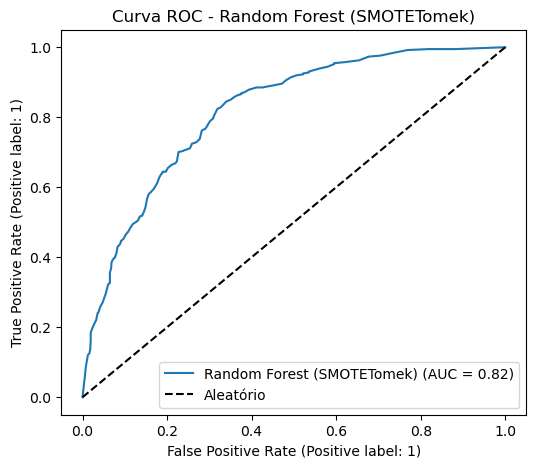

In [48]:
auc_rf_smote = roc_auc_score(y_test, y_proba_rf_smote)
print(f"\nAUC-ROC (Random Forest com SMOTETomek): {auc_rf_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_smote_model, X_test, y_test, ax=ax, name='Random Forest (SMOTETomek)')
plt.title('Curva ROC - Random Forest (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

### SVM

SVM é um poderoso algoritmo de classificação que busca encontrar o hiperplano que melhor separa as classes.

Observação: SVC com probability=True é necessário para usar predict_proba e, consequentemente, calcular o AUC-ROC. Isso pode aumentar o tempo de treinamento.



--- Treinando e Avaliando o Modelo SVM com SMOTETomek ---

--- Relatório de Classificação (SVM com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.73      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


--- Matriz de Confusão (SVM com SMOTETomek) ---


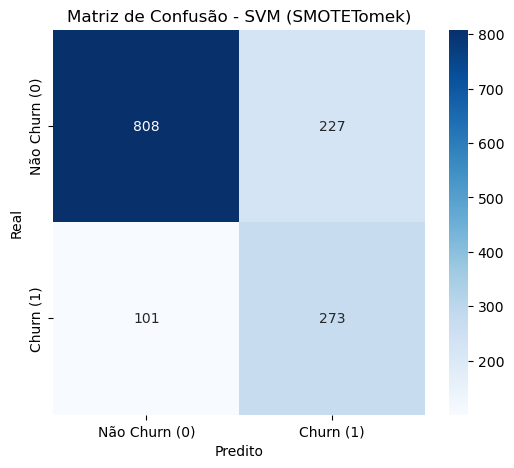


AUC-ROC (SVM com SMOTETomek): 0.8233


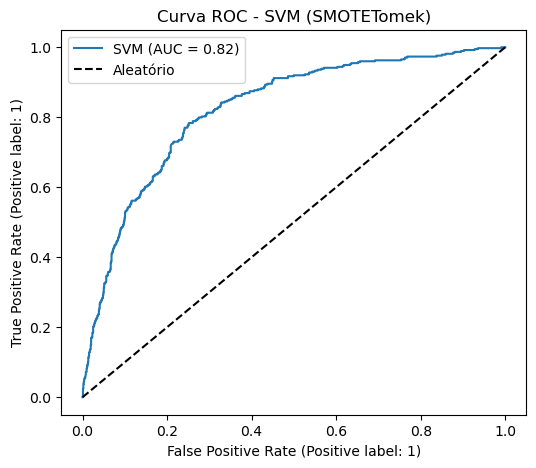

In [49]:
print("\n\n--- Treinando e Avaliando o Modelo SVM com SMOTETomek ---")

# Inicializar o modelo SVM
# kernel='rbf' é um bom default para a maioria dos casos
# probability=True para poder calcular predict_proba (necessário para AUC-ROC)
# random_state para reprodutibilidade
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Treinar o modelo
svm_model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de teste
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avaliação
print("\n--- Relatório de Classificação (SVM com SMOTETomek) ---")
print(classification_report(y_test, y_pred_svm))

print("\n--- Matriz de Confusão (SVM com SMOTETomek) ---")
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - SVM (SMOTETomek)')
plt.show()

auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"\nAUC-ROC (SVM com SMOTETomek): {auc_svm:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(svm_model, X_test, y_test, ax=ax, name='SVM')
plt.title('Curva ROC - SVM (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

### Decision Tree 

Uma Árvore de Decisão toma decisões com base em regras if-else aprendidas a partir dos dados. É simples e interpretável, mas pode ser propensa a overfitting.



--- Treinando e Avaliando o Modelo Decision Tree com SMOTETomek ---

--- Relatório de Classificação (Decision Tree com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1035
           1       0.50      0.61      0.55       374

    accuracy                           0.73      1409
   macro avg       0.67      0.69      0.68      1409
weighted avg       0.75      0.73      0.74      1409


--- Matriz de Confusão (Decision Tree com SMOTETomek) ---


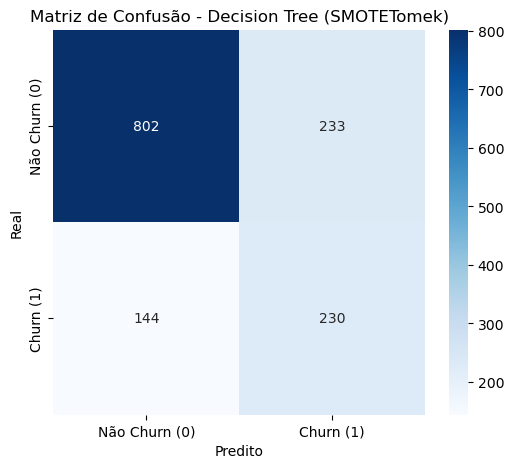


AUC-ROC (Decision Tree com SMOTETomek): 0.6958


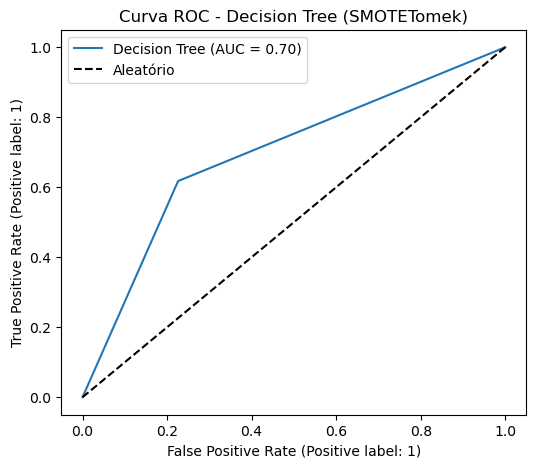

In [50]:
print("\n\n--- Treinando e Avaliando o Modelo Decision Tree com SMOTETomek ---")

# Inicializar o modelo Decision Tree
# random_state para reprodutibilidade
dt_model = DecisionTreeClassifier(random_state=42)

# Treinar o modelo
dt_model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de teste
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avaliação
print("\n--- Relatório de Classificação (Decision Tree com SMOTETomek) ---")
print(classification_report(y_test, y_pred_dt))

print("\n--- Matriz de Confusão (Decision Tree com SMOTETomek) ---")
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Decision Tree (SMOTETomek)')
plt.show()

auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"\nAUC-ROC (Decision Tree com SMOTETomek): {auc_dt:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(dt_model, X_test, y_test, ax=ax, name='Decision Tree')
plt.title('Curva ROC - Decision Tree (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

### XGBoost

XGBoost é um algoritmo de gradient boosting que constrói árvores de decisão sequencialmente, corrigindo os erros das árvores anteriores. É conhecido por sua alta performance e robustez.



--- Treinando e Avaliando o Modelo XGBoost com SMOTETomek ---

--- Relatório de Classificação (XGBoost com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409


--- Matriz de Confusão (XGBoost com SMOTETomek) ---


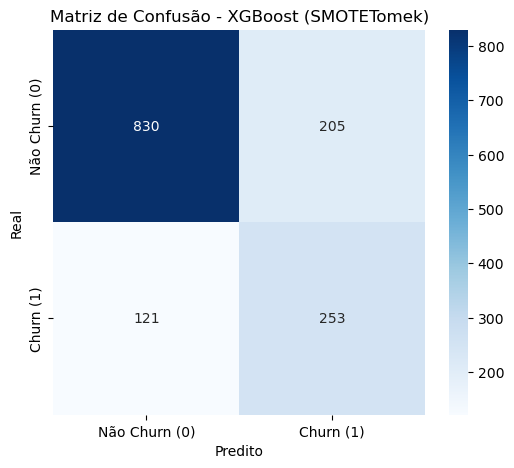


AUC-ROC (XGBoost com SMOTETomek): 0.8169


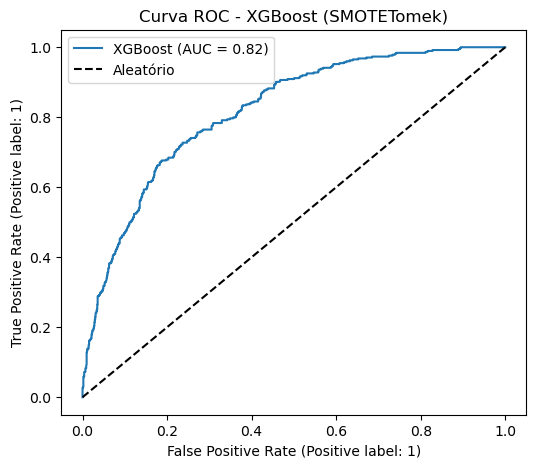

In [51]:
print("\n\n--- Treinando e Avaliando o Modelo XGBoost com SMOTETomek ---")

# Inicializar o modelo XGBoost
# objective='binary:logistic' para classificação binária
# eval_metric='logloss' para avaliação do logloss
# use_label_encoder=False para evitar o warning (dependendo da versão)
# random_state para reprodutibilidade
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Treinar o modelo
xgb_model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de teste
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avaliação
print("\n--- Relatório de Classificação (XGBoost com SMOTETomek) ---")
print(classification_report(y_test, y_pred_xgb))

print("\n--- Matriz de Confusão (XGBoost com SMOTETomek) ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - XGBoost (SMOTETomek)')
plt.show()

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"\nAUC-ROC (XGBoost com SMOTETomek): {auc_xgb:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, name='XGBoost')
plt.title('Curva ROC - XGBoost (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

### LightGBM

LightGBM é outro algoritmo de gradient boosting, otimizado para velocidade e eficiência, especialmente com grandes datasets.



--- Treinando e Avaliando o Modelo LightGBM com SMOTETomek ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3965, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 7930, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Relatório de Classificação (LightGBM com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.69      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.7

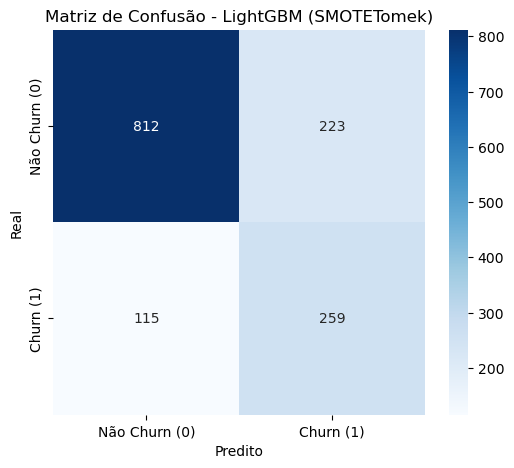


AUC-ROC (LightGBM com SMOTETomek): 0.8268


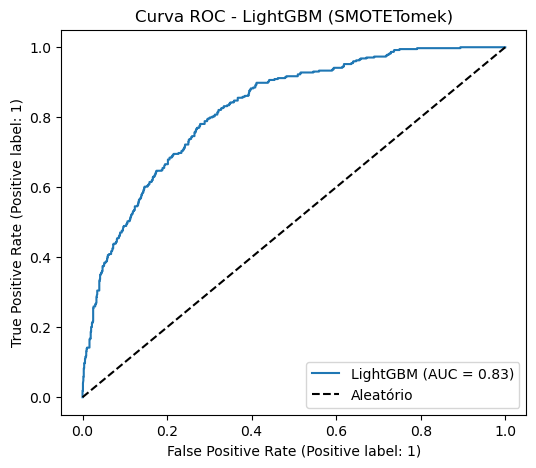

In [52]:
print("\n\n--- Treinando e Avaliando o Modelo LightGBM com SMOTETomek ---")

# Inicializar o modelo LightGBM
# objective='binary' para classificação binária
# metric='binary_logloss' para avaliação do logloss
# random_state para reprodutibilidade
lgbm_model = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)

# Treinar o modelo
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de teste
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avaliação
print("\n--- Relatório de Classificação (LightGBM com SMOTETomek) ---")
print(classification_report(y_test, y_pred_lgbm))

print("\n--- Matriz de Confusão (LightGBM com SMOTETomek) ---")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - LightGBM (SMOTETomek)')
plt.show()

auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print(f"\nAUC-ROC (LightGBM com SMOTETomek): {auc_lgbm:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax, name='LightGBM')
plt.title('Curva ROC - LightGBM (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

### K-Nearest Neighbors (KNN)

KNN é um algoritmo não-paramétrico que classifica um ponto de dados com base na maioria dos votos de seus k vizinhos mais próximos. É sensível à escala dos dados e à escolha de k.



--- Treinando e Avaliando o Modelo K-Nearest Neighbors (KNN) com SMOTETomek ---

--- Relatório de Classificação (KNN com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1035
           1       0.48      0.74      0.58       374

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.68      1409
weighted avg       0.77      0.72      0.73      1409


--- Matriz de Confusão (KNN com SMOTETomek) ---


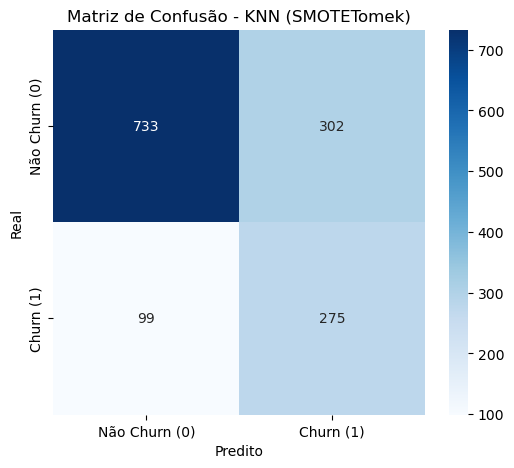


AUC-ROC (KNN com SMOTETomek): 0.7799


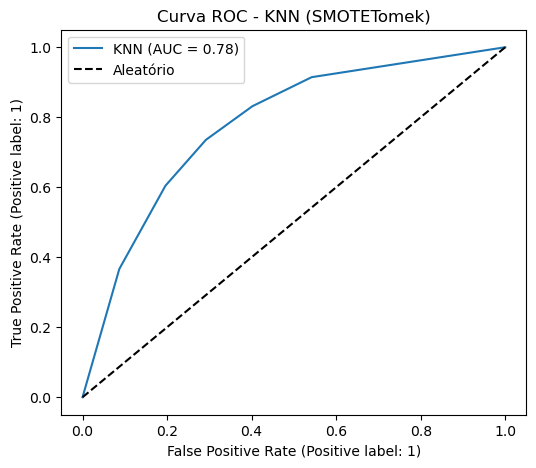

In [53]:
print("\n\n--- Treinando e Avaliando o Modelo K-Nearest Neighbors (KNN) com SMOTETomek ---")

# Inicializar o modelo KNN
# n_neighbors=5 é um valor inicial comum, pode ser otimizado
knn_model = KNeighborsClassifier(n_neighbors=5)

# Treinar o modelo
knn_model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de teste
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avaliação
print("\n--- Relatório de Classificação (KNN com SMOTETomek) ---")
print(classification_report(y_test, y_pred_knn))

print("\n--- Matriz de Confusão (KNN com SMOTETomek) ---")
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - KNN (SMOTETomek)')
plt.show()

auc_knn = roc_auc_score(y_test, y_proba_knn)
print(f"\nAUC-ROC (KNN com SMOTETomek): {auc_knn:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(knn_model, X_test, y_test, ax=ax, name='KNN')
plt.title('Curva ROC - KNN (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()


### Tabela Resumo dos Resultados

Para facilitar a comparação, compilei as métricas mais relevantes para a classe **`1` (Churn)** para todos os modelos que você testou:

| Modelo                     | Abordagem               | Precisão (Churn=1) | Recall (Churn=1) | F1-Score (Churn=1) | AUC-ROC |
| :------------------------- | :---------------------- | :----------------- | :--------------- | :----------------- | :------ |
| Regressão Logística        | `class_weight='balanced'` | 0.51               | **0.78**         | 0.62               | **0.8389**|
| Random Forest              | `class_weight='balanced'` | **0.63**           | 0.49             | 0.55               | 0.8195  |
| Regressão Logística        | SMOTETomek              | 0.53               | 0.74             | 0.62               | 0.8323  |
| Random Forest              | SMOTETomek              | 0.55               | 0.64             | 0.59               | 0.8167  |
| SVM                        | SMOTETomek              | 0.55               | 0.73             | 0.62               | 0.8233  |
| Decision Tree              | SMOTETomek              | 0.50               | 0.61             | 0.55               | 0.6958  |
| XGBoost                    | SMOTETomek              | 0.55               | 0.68             | 0.61               | 0.8169  |
| LightGBM                   | SMOTETomek              | 0.54               | 0.69             | 0.61               | 0.8268  |
| K-Nearest Neighbors (KNN)  | SMOTETomek              | 0.48               | **0.74**         | 0.58               | 0.7799  |

*(Os valores nas colunas podem ter pequenas variações decimais devido ao arredondamento dos relatórios, mas a ordem de grandeza e comparação são mantidas)*

---

### Análise Detalhada dos Resultados por Modelo e Abordagem

#### **1. Regressão Logística (`class_weight='balanced'`)**
*   **Recall (Churn): 0.78** - Muito bom! Conseguiu identificar 78% dos clientes que realmente iriam cancelar. Isso minimiza **Falsos Negativos** (clientes que cancelam mas o modelo não previu).
*   **Precisão (Churn): 0.51** - Moderada. Dos clientes que o modelo previu que iriam cancelar, apenas 51% realmente cancelaram. Isso significa muitos **Falsos Positivos** (o modelo previu churn, mas não houve).
*   **F1-Score (Churn): 0.62** - Bom, reflete o equilíbrio entre precisão e recall.
*   **AUC-ROC: 0.8389** - Excelente! Indica uma forte capacidade de discriminar entre churners e não-churners.
*   **Conclusão:** Este modelo é **agressivo em capturar churners**, o que é ótimo para estratégias de retenção onde o custo de perder um cliente é alto. No entanto, o custo de uma intervenção em um falso positivo deve ser considerado.

#### **2. Random Forest (`class_weight='balanced'`)**
*   **Recall (Churn): 0.49** - Mediano. Identifica menos da metade dos churners reais.
*   **Precisão (Churn): 0.63** - Melhor que a Regressão Logística. É mais seletivo e tem menos falsos positivos.
*   **F1-Score (Churn): 0.55** - Inferior à Regressão Logística, refletindo o Recall mais baixo.
*   **AUC-ROC: 0.8195** - Bom, mas ligeiramente inferior à Regressão Logística.
*   **Conclusão:** Este modelo é mais **conservador** em prever churn. Ele é mais preciso quando prevê churn, mas perde muitos clientes que de fato cancelam. Bom se o custo de uma ação de retenção for muito alto e você só quiser intervir nos casos mais prováveis.

#### **3. Regressão Logística (SMOTETomek)**
*   **Recall (Churn): 0.74** - Ligeiramente menor que a RL com `class_weight`.
*   **Precisão (Churn): 0.53** - Ligeiramente maior que a RL com `class_weight`.
*   **F1-Score (Churn): 0.62** - Permanece o mesmo.
*   **AUC-ROC: 0.8323** - Ligeiramente menor que a RL com `class_weight`.
*   **Conclusão:** A abordagem SMOTETomek alterou a troca entre Precisão e Recall de forma marginal para a Regressão Logística, mas o Recall para Churn diminuiu um pouco e o AUC também.

#### **4. Random Forest (SMOTETomek)**
*   **Recall (Churn): 0.64** - Houve um **aumento significativo** no Recall (de 0.49 para 0.64) em comparação com o RF usando `class_weight`.
*   **Precisão (Churn): 0.55** - Houve uma **queda** na Precisão (de 0.63 para 0.55).
*   **F1-Score (Churn): 0.59** - Melhorou (de 0.55 para 0.59), indicando um melhor equilíbrio geral pós-SMOTETomek.
*   **AUC-ROC: 0.8167** - Ligeiramente menor que o RF com `class_weight`.
*   **Conclusão:** Para Random Forest, SMOTETomek claramente **priorizou o Recall**, tornando-o mais eficaz em identificar churners, mas à custa de mais falsos positivos. Isso é uma mudança positiva se o objetivo for capturar mais churners.

#### **5. SVM (SMOTETomek)**
*   **Recall (Churn): 0.73** - Muito bom, competitivo com a Regressão Logística.
*   **Precisão (Churn): 0.55** - Razoável.
*   **F1-Score (Churn): 0.62** - Bom.
*   **AUC-ROC: 0.8233** - Bom.
*   **Conclusão:** O SVM com SMOTETomek apresenta um desempenho bastante equilibrado, com bom Recall e AUC, sendo um forte candidato.

#### **6. Decision Tree (SMOTETomek)**
*   **Recall (Churn): 0.61** - Razoável.
*   **Precisão (Churn): 0.50** - Baixa.
*   **F1-Score (Churn): 0.55** - Baixo.
*   **AUC-ROC: 0.6958** - **Significativamente mais baixo** que os outros modelos.
*   **Conclusão:** A Árvore de Decisão, sem otimização de hiperparâmetros, não performou bem. Sua baixa AUC sugere que ela não consegue discriminar bem entre as classes, provavelmente devido a overfitting ou à sua natureza mais simples comparada aos ensembles.

#### **7. XGBoost (SMOTETomek)**
*   **Recall (Churn): 0.68** - Bom.
*   **Precisão (Churn): 0.55** - Razoável.
*   **F1-Score (Churn): 0.61** - Bom.
*   **AUC-ROC: 0.8169** - Bom.
*   **Conclusão:** O XGBoost apresenta um bom equilíbrio entre Recall e Precisão, com um F1-Score sólido e AUC competitivo. É uma escolha robusta.

#### **8. LightGBM (SMOTETomek)**
*   **Recall (Churn): 0.69** - Muito bom, ligeiramente melhor que XGBoost.
*   **Precisão (Churn): 0.54** - Razoável.
*   **F1-Score (Churn): 0.61** - Bom.
*   **AUC-ROC: 0.8268** - Muito bom, competitivo com os melhores AUCs.
*   **Conclusão:** LightGBM é ligeiramente superior ao XGBoost em termos de Recall e AUC neste cenário, sendo outro forte candidato. É notável sua eficiência computacional.

#### **9. K-Nearest Neighbors (KNN) (SMOTETomek)**
*   **Recall (Churn): 0.74** - Muito bom, similar à Regressão Logística!
*   **Precisão (Churn): 0.48** - **Baixa.** Este é o pior resultado de Precisão entre todos os modelos.
*   **F1-Score (Churn): 0.58** - Mediano, mas impactado pela baixa Precisão.
*   **AUC-ROC: 0.7799** - O mais baixo entre os modelos promissores, sugerindo menos poder de discriminação geral.
*   **Conclusão:** O KNN é muito bom em capturar churners, mas gera um número extremamente alto de falsos positivos, o que poderia tornar as ações de retenção muito caras e ineficientes.

---

### Por que a Regressão Logística (`class_weight='balanced'`) Teve Melhor Performance (em Recall e AUC) que a RL com SMOTETomek?

Sua observação é **extremamente perspicaz** e toca em um ponto crucial da ciência de dados!

Ao comparar:

*   **Regressão Logística (`class_weight='balanced'`):** Recall (1)=**0.78**, Precisão (1)=0.51, AUC=**0.8389**
*   **Regressão Logística (SMOTETomek):** Recall (1)=0.74, Precisão (1)=**0.53**, AUC=0.8323

Você está correto: a versão `class_weight='balanced'` da Regressão Logística obteve um Recall para a classe Churn ligeiramente maior e uma AUC superior, apesar de uma Precisão um pouco menor.

**Razões para este comportamento:**

1.  **Natureza da Regressão Logística (Modelo Linear) e `class_weight`:**
    *   A Regressão Logística é um **modelo linear**. Ela tenta encontrar um hiperplano (uma linha ou superfície) para separar as classes.
    *   O parâmetro `class_weight='balanced'` atua como um **ajuste de custo (cost-sensitive learning)**. Ele não altera a distribuição física dos dados de treinamento, mas informa ao algoritmo que os erros na classe minoritária são mais \\\"caros\\\" durante o processo de otimização (minimização da função de perda). Isso faz com que a fronteira de decisão linear do modelo se incline para \\\"proteger\\\" a classe minoritária, mesmo que isso signifique um aumento nos falsos positivos para a classe majoritária.
    *   Para problemas onde a separabilidade é razoavelmente linear (ou linear após as transformações de features que você já fez), esse ajuste de custo pode ser muito eficaz e direto, movendo a fronteira de decisão de forma otimizada para capturar a classe minoritária.

2.  **Limitações do SMOTE e Complexidade dos Dados Sintéticos:**
    *   **Geração de Amostras Sintéticas:** SMOTE cria novas amostras interpolando entre as amostras existentes. Embora seja melhor do que oversampling aleatório, as amostras sintéticas podem, em alguns casos:
        *   **Introduzir Ruído:** Se a classe minoritária é intrinsecamente ruidosa ou tem muitos outliers, o SMOTE pode gerar amostras sintéticas que amplificam esse ruído ou assemelham-se a outliers.
        *   **Não Capturar a Verdadeira Complexidade:** Se a verdadeira fronteira de decisão é muito complexa e não-linear, os pontos sintéticos gerados linearmente entre vizinhos podem não representar fielmente a distribuição subjacente da classe minoritária, levando o modelo a aprender uma fronteira menos ideal.
        *   **Over-generalization:** Às vezes, o SMOTE pode criar regiões densas de pontos sintéticos que fazem o modelo generalizar demais para a classe minoritária, até mesmo em áreas onde a classe majoritária deveria dominar, resultando em mais falsos positivos e, por vezes, uma leve queda na capacidade de discriminação geral (AUC).
    *   **Impacto no Conjunto de Teste Original:** O modelo treinado com SMOTETomek é exposto a uma distribuição de treinamento alterada. Quando avaliado no conjunto de teste *original* (desbalanceado), pode ser que a fronteira de decisão aprendida no dataset reamostrado não se generalize tão bem à distribuição natural dos dados como a fronteira linear ajustada por `class_weight`. A técnica `class_weight` nunca \"mentiu\" sobre o número real de samples, apenas alterou a penalidade.

3.  **Natureza do Tomek Links:** A remoção de Tomek Links visa limpar a fronteira. No entanto, se um ponto da classe majoritária é um Tomek Link para um ponto da minoritária, sua remoção pode, em certos cenários, remover informações que ajudariam o modelo a aprender uma fronteira mais fina e complexa, ou remover pontos que eram importantes para delimitar a região da classe majoritária.

**Em resumo:** Para o modelo linear de Regressão Logística neste dataset específico, o método `class_weight='balanced'` pareceu ser um **ajuste mais direto e eficaz** para o problema de desbalanceamento, sem a potencial complexidade ou introdução de ruído que a geração de dados sintéticos pelo SMOTETomek pode, ocasionalmente, trazer. É uma prova de que nem sempre a técnica mais complexa é a melhor; a experimentação é fundamental.

---

### Considerações e Próximos Passos Sugeridos

Você tem agora uma excelente visão do desempenho de vários modelos.

**Melhores Modelos Atuais (com base no Recall e AUC para Churn):**

1.  **Regressão Logística (`class_weight='balanced'`):** Ótimo Recall (0.78) e o melhor AUC (0.8389). Sua desvantagem é a Precisão mais baixa (0.51).
2.  **SVM (SMOTETomek):** Bom Recall (0.73) e F1-Score (0.62), com bom AUC (0.8233).
3.  **LightGBM (SMOTETomek):** Bom Recall (0.69) e um dos melhores AUCs (0.8268), com F1-Score competitivo (0.61).
4.  **XGBoost (SMOTETomek):** Desempenho muito próximo ao LightGBM, ligeiramente menor Recall e AUC, mas ainda forte.

**Próximos Passos:**

1.  **Definir Prioridade de Negócio:**
    *   **Qual é mais importante para o seu projeto: Minimizar Falsos Negativos (altíssimo Recall, capturar *todos* os churners, mesmo com muitos Falsos Positivos)** ou **Minimizar Falsos Positivos (altíssima Precisão, intervir *apenas* em churners muito prováveis, mesmo que perca alguns)**?
    *   Se perder um cliente custa muito (alto LTV), o Recall é mais crítico (Regressão Logística com `class_weight` e SVM com SMOTE são fortes).
    *   Se as ações de retenção são caras ou intrusivas, a Precisão é mais crítica (Random Forest com `class_weight` seria uma opção, mas o Recall é muito baixo).
    *   Se busca um equilíbrio, F1-Score e AUC são guias.

2.  **Otimização de Hiperparâmetros (Hyperparameter Tuning):**
    *   Nenhum dos modelos foi otimizado além dos parâmetros padrão ou valores básicos (`n_estimators`). A otimização pode melhorar significativamente o desempenho, especialmente para modelos como Random Forest, XGBoost, LightGBM e SVM.
    *   **Recomendação:** Utilize `GridSearchCV` ou `RandomizedSearchCV` com **cross-validation estratégica** (por exemplo, `StratifiedKFold` para manter a proporção das classes em cada fold, se você ainda for usar `class_weight` ou se a reamostragem for aplicada dentro do pipeline de validação cruzada).
    *   Para os modelos treinados com SMOTETomek, o tuning será feito em `X_train_resampled`.
    *   Para os modelos `class_weight='balanced'`, o tuning será em `X_train`.

3.  **Ajuste do Ponto de Corte (Threshold Optimization):**
    *   A maioria dos classificadores tem um ponto de corte padrão de 0.5. Você pode ajustar esse limiar de probabilidade para otimizar o Recall ou a Precisão, dependendo do objetivo de negócio.
    *   **Ferramentas:** Curva de Precisão-Recall (Precision-Recall Curve) e Curva ROC podem ajudar a visualizar a troca entre essas métricas em diferentes limiares.

4.  **Engenharia de Features Adicional:**
    *   Será que há mais insights a serem extraídos dos dados ou novas features a serem criadas (ex: interações entre features)?
    *   Analisar as **feature importances** dos modelos baseados em árvores (Random Forest, XGBoost, LightGBM) pode fornecer insights sobre quais variáveis são mais importantes na previsão de churn, o que pode guiar novas estratégias de negócio ou a criação de novas features.

5.  **Conjunto de Validação (Opcional, mas Recomendado):** Para uma avaliação ainda mais robusta, especialmente após o tuning, pode-se separar um pequeno conjunto de validação do treinamento original (além do teste).

6.  **Modelos Ensemble / Stacking (Futuro):** Após otimizar os modelos individuais, você pode tentar combinar as previsões dos melhores modelos (por exemplo, a Regressão Logística e o LightGBM) usando técnicas de ensemble ou stacking para tentar obter um desempenho ainda melhor.

Você está no caminho certo para construir um modelo robusto de previsão de churn!

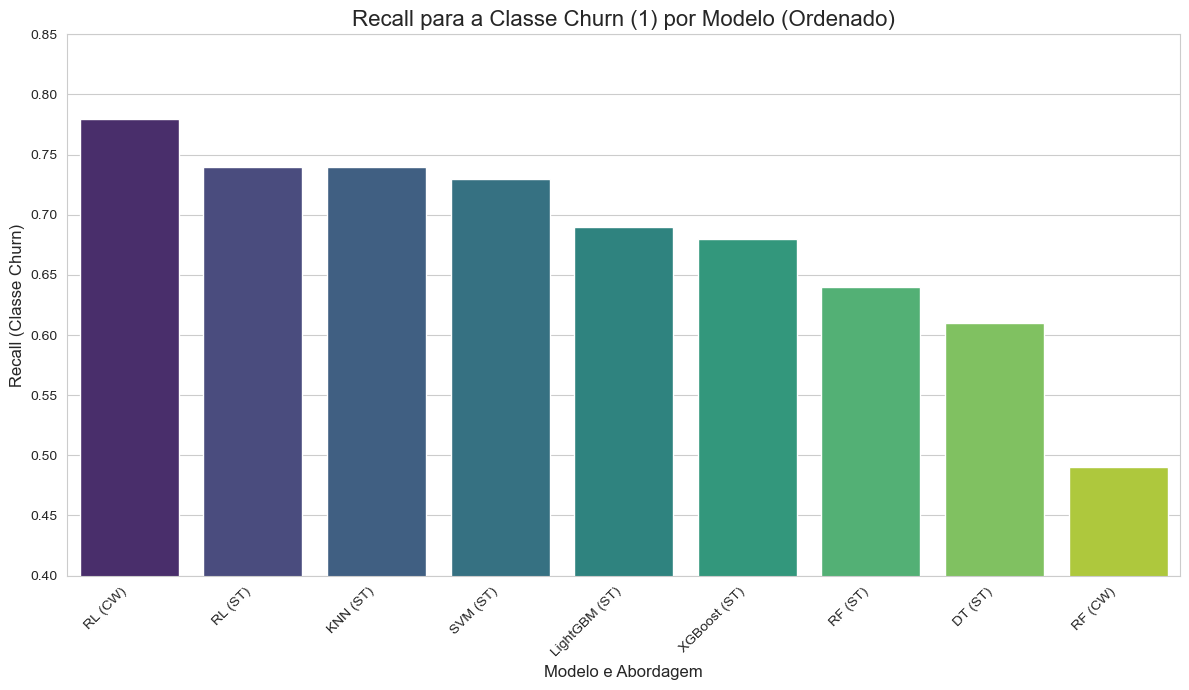

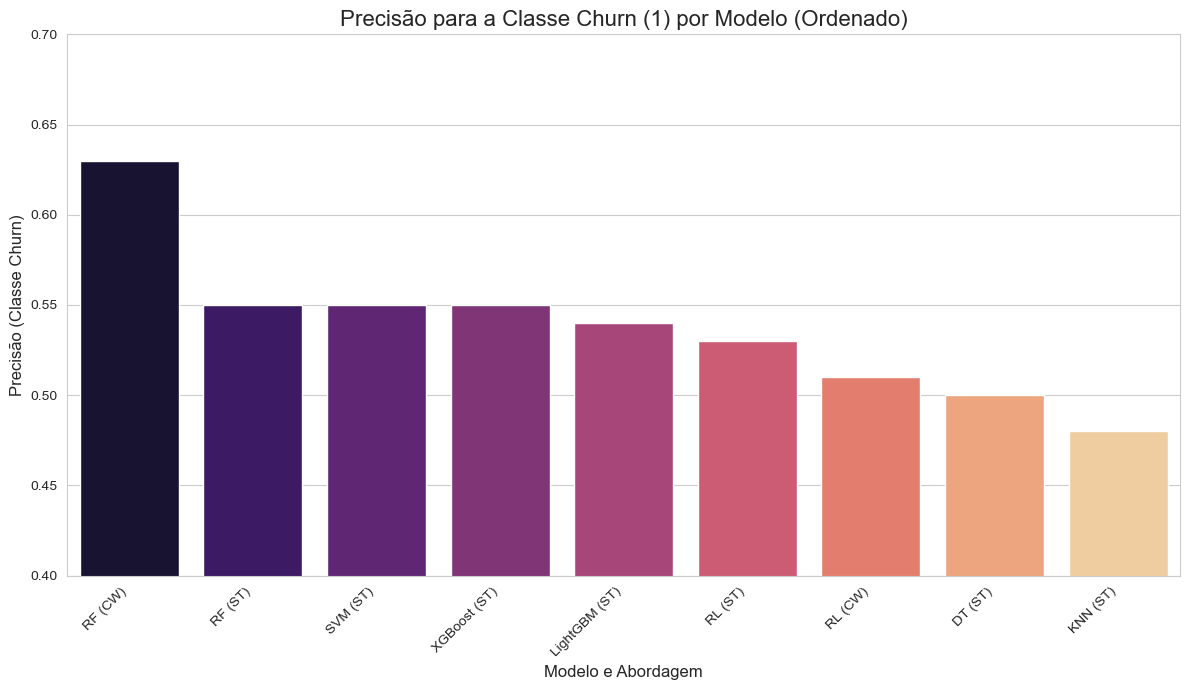

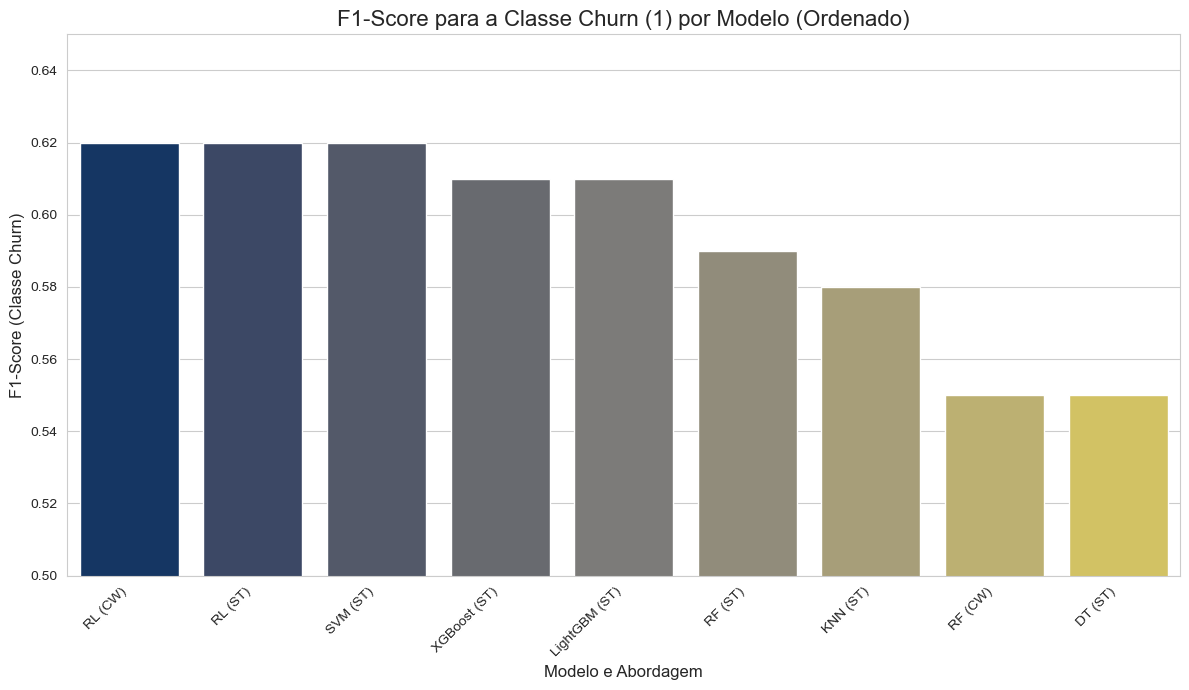

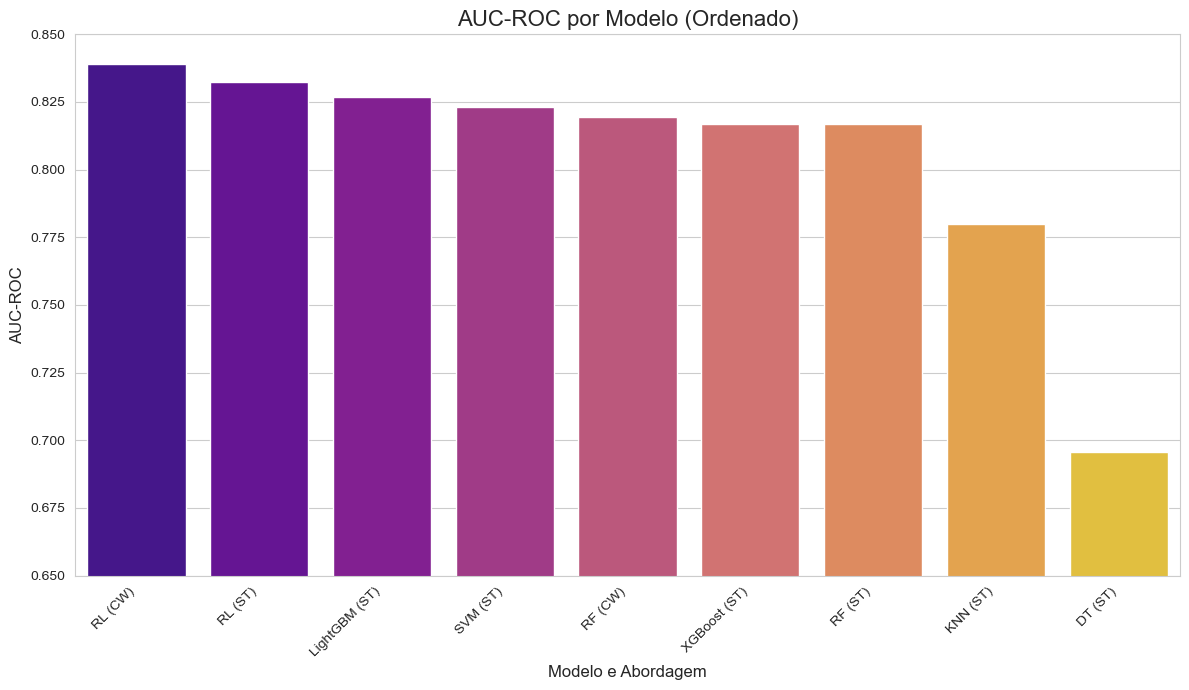

In [57]:
# --- Dados da Tabela de Resultados ---
data = {
    'Modelo': [
        'Regressão Logística', 'Random Forest',
        'Regressão Logística', 'Random Forest',
        'SVM', 'Decision Tree', 'XGBoost', 'LightGBM', 'K-Nearest Neighbors (KNN)'
    ],
    'Abordagem': [
        'class_weight=\'balanced\'', 'class_weight=\'balanced\'',
        'SMOTETomek', 'SMOTETomek', 'SMOTETomek',
        'SMOTETomek', 'SMOTETomek', 'SMOTETomek', 'SMOTETomek'
    ],
    'Precisão (Churn=1)': [0.51, 0.63, 0.53, 0.55, 0.55, 0.50, 0.55, 0.54, 0.48],
    'Recall (Churn=1)': [0.78, 0.49, 0.74, 0.64, 0.73, 0.61, 0.68, 0.69, 0.74],
    'F1-Score (Churn=1)': [0.62, 0.55, 0.62, 0.59, 0.62, 0.55, 0.61, 0.61, 0.58],
    'AUC-ROC': [0.8389, 0.8195, 0.8323, 0.8167, 0.8233, 0.6958, 0.8169, 0.8268, 0.7799]
}

df_results = pd.DataFrame(data)

# Criar uma coluna combinada para rótulos mais curtos nos gráficos
df_results['Modelo_Label'] = df_results['Modelo'].apply(lambda x: x.replace('Regressão Logística', 'RL').replace('Random Forest', 'RF').replace('Decision Tree', 'DT').replace('K-Nearest Neighbors (KNN)', 'KNN')) + " (" + df_results['Abordagem'].apply(lambda x: 'CW' if 'class_weight' in x else 'ST') + ")"

# --- Configurações de Plotagem ---
sns.set_style("whitegrid") # Estilo dos gráficos
plt.rcParams['figure.figsize'] = (10, 6) # Tamanho padrão da figura

# --- Gráfico de Barras para Recall (Churn=1) ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pelo Recall (Churn=1) em ordem decrescente para este gráfico
df_sorted_recall = df_results.sort_values(by='Recall (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Recall (Churn=1)', data=df_sorted_recall, palette='viridis')
plt.title('Recall para a Classe Churn (1) por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('Recall (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.85)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gráfico de Barras para Precisão (Churn=1) ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pela Precisão (Churn=1) em ordem decrescente para este gráfico
df_sorted_precision = df_results.sort_values(by='Precisão (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Precisão (Churn=1)', data=df_sorted_precision, palette='magma')
plt.title('Precisão para a Classe Churn (1) por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('Precisão (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gráfico de Barras para F1-Score (Churn=1) ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pelo F1-Score (Churn=1) em ordem decrescente para este gráfico
df_sorted_f1 = df_results.sort_values(by='F1-Score (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='F1-Score (Churn=1)', data=df_sorted_f1, palette='cividis')
plt.title('F1-Score para a Classe Churn (1) por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('F1-Score (Classe Churn)', fontsize=12)
plt.ylim(0.5, 0.65)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gráfico de Barras para AUC-ROC ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pelo AUC-ROC em ordem decrescente para este gráfico
df_sorted_auc = df_results.sort_values(by='AUC-ROC', ascending=False)
sns.barplot(x='Modelo_Label', y='AUC-ROC', data=df_sorted_auc, palette='plasma')
plt.title('AUC-ROC por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Justificativa: Por que o Recall é Crucial na Previsão de Churn (sem menosprezar outras métricas)
No contexto da previsão de churn de clientes, o Recall (também conhecido como Sensibilidade ou Cobertura) é a métrica primária a ser otimizada. Ele mede a capacidade do nosso modelo em identificar corretamente a maior proporção possível de clientes que realmente vão deixar a empresa (a classe minoritária "Churn").

Por que priorizamos o Recall?

Minimização de Perdas de Clientes (Falsos Negativos): O custo de um Falso Negativo (um cliente que o modelo previu que não iria ter churn, mas que na verdade cancelou) é geralmente muito alto para uma empresa. Cada cliente perdido representa não apenas a interrupção de receita futura, mas também a potencial perda de valor de vida útil (Lifetime Value - LTV), custos de aquisição de novos clientes e impacto negativo na reputação. Um Recall alto significa que estamos minimizando esses Falsos Negativos, garantindo que a maioria dos clientes em risco de churn seja sinalizada para intervenção.

Oportunidade de Intervenção Proativa: Ao identificar um cliente com alta probabilidade de churn (graças a um Recall elevado), a empresa ganha a oportunidade de implementar estratégias de retenção direcionadas (ofertas personalizadas, suporte proativo, pesquisas de satisfação). Perder essa oportunidade por um Falso Negativo é o erro mais custoso neste cenário.

Importância das Outras Métricas:

Embora o Recall seja a prioridade, não menosprezamos a Precisão, o F1-Score e a AUC-ROC:

Precisão: Controla o custo das intervenções. Uma Precisão muito baixa (muitos Falsos Positivos – clientes que o modelo previu que iriam ter churn, mas que na verdade não iriam) pode levar ao desperdício de recursos em ações de retenção desnecessárias ou, pior, a irritar clientes satisfeitos. Buscamos um equilíbrio: queremos capturar a maioria dos churners (alto Recall), mas sem gastar excessivamente ou incomodar clientes que não precisam de intervenção (Precisão razoável).
F1-Score: Oferece uma visão equilibrada do modelo, ponderando a Precisão e o Recall. É útil para comparar modelos que podem ter diferentes compensações entre essas duas métricas.
AUC-ROC: Mede a capacidade geral de discriminação do modelo entre as classes. Um alto AUC indica que o modelo é bom em ranquear corretamente as probabilidades de churn, o que é valioso para definir pontos de corte e estratégias de segmentação.
Em resumo, nosso foco é garantir que o maior número possível de clientes em risco de churn seja identificado (alto Recall), permitindo ações de retenção eficazes. As outras métricas nos ajudam a refinar o modelo, garantindo que essas intervenções sejam tão eficientes e direcionadas quanto possível, otimizando o retorno sobre o investimento em prevenção de churn.

### Otimização dos Hiperparametros

a Regressão Logística com class_weight='balanced' apresentou um Recall e AUC superiores (0.78 e 0.8389, respectivamente) em comparação com a mesma Regressão Logística com SMOTETomek (0.74 e 0.8323) é um indicativo forte de que nem sempre a técnica de reamostragem mais complexa é a melhor solução.

Justificativa para Treinar Modelos sem SMOTETomek (Focando em class_weight ou Equivalentes)
Sua sugestão é perfeitamente válida e, de fato, a abordagem correta quando os resultados iniciais apontam para essa direção. Aqui está a justificativa que pode ser usada no seu projeto:

"Embora técnicas de reamostragem como SMOTETomek sejam poderosas para lidar com o desbalanceamento de classes, a experimentação prática revelou que, para o nosso conjunto de dados e para a otimização do Recall na previsão de Churn, abordagens intrínsecas aos modelos, como o parâmetro class_weight='balanced' ou scale_pos_weight, demonstraram maior eficácia inicial.

A principal vantagem de utilizar esses parâmetros é que eles ajustam o processo de aprendizado do modelo de forma a penalizar mais severamente os erros na classe minoritária (Churn), sem a necessidade de modificar a distribuição original dos dados de treinamento através da criação de amostras sintéticas ou remoção de amostras reais.

Para modelos lineares como a Regressão Logística, e para modelos baseados em árvores que podem lidar com pesos de amostra, essa abordagem de 'custo sensível' muitas vezes permite que o algoritmo encontre uma fronteira de decisão mais robusta e generalizável para o problema desbalanceado, refletindo melhor a realidade dos dados no conjunto de teste. O uso de class_weight ou scale_pos_weight evita a potencial introdução de ruído ou a criação de padrões artificiais que, em alguns casos, podem ocorrer com a geração de dados sintéticos (SMOTE), mesmo quando combinada com técnicas de limpeza (Tomek Links).

Portanto, para a fase de otimização de hiperparâmetros, priorizaremos modelos que utilizam esses mecanismos internos de balanceamento, buscando maximizar o Recall da classe Churn de forma mais eficiente."

Códigos Python para Otimização de Hiperparâmetros (Sem SMOTETomek)
Vamos otimizar os hiperparâmetros dos seguintes modelos, utilizando o class_weight='balanced' ou o equivalente scale_pos_weight, que é mais comum em modelos de boosting:

Regressão Logística (class_weight='balanced')
Random Forest Classifier (class_weight='balanced')
Support Vector Machine (SVM) (class_weight='balanced')
XGBoost Classifier (scale_pos_weight)
LightGBM Classifier (scale_pos_weight)
Antes de iniciar, precisamos calcular o scale_pos_weight, que é a razão entre o número de amostras da classe majoritária e o número de amostras da classe minoritária no conjunto de treinamento.

In [59]:
count_class_0 = y_train.value_counts()[0]
count_class_1 = y_train.value_counts()[1]
scale_pos_weight_value = count_class_0 / count_class_1

print(f"Número de Não Churn (classe 0) no treino: {count_class_0}")
print(f"Número de Churn (classe 1) no treino: {count_class_1}")
print(f"scale_pos_weight calculado: {scale_pos_weight_value:.4f}")

# Definir a métrica de scoring para a validação cruzada
# Priorizamos o Recall da classe 1 (Churn)
recall_scorer = make_scorer(recall_score, pos_label=1)

Número de Não Churn (classe 0) no treino: 4139
Número de Churn (classe 1) no treino: 1495
scale_pos_weight calculado: 2.7686


1. Regressão Logística (class_weight='balanced')
Justificativa: A Regressão Logística, sendo um modelo linear, se beneficia diretamente do class_weight='balanced' ajustando a função de custo para penalizar mais os erros da classe minoritária, sem alterar a distribuição dos dados.


--- Otimizando Hiperparâmetros para Regressão Logística (class_weight='balanced') ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores Parâmetros (Regressão Logística): {'C': 0.001}
Melhor Recall (Regressão Logística) no CV: 0.7946

--- Relatório de Classificação (Regressão Logística Tuned) ---
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



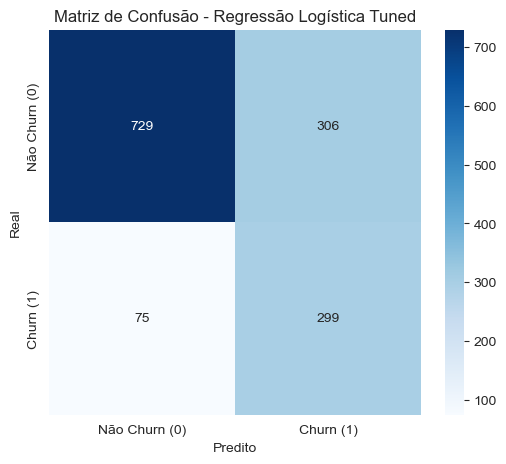

AUC-ROC (Regressão Logística Tuned): 0.8353


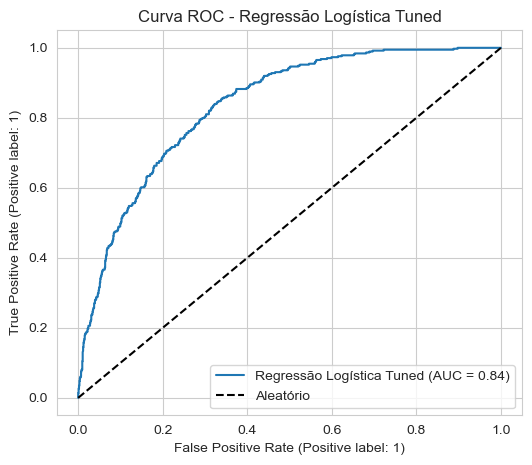

In [62]:
print("\n--- Otimizando Hiperparâmetros para Regressão Logística (class_weight='balanced') ---")

log_reg_base = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)

param_grid_lr = {
    'C': np.logspace(-3, 2, 6) # Parâmetro de regularização (inverso da força de regularização)
}

grid_search_lr = GridSearchCV(estimator=log_reg_base,
                              param_grid=param_grid_lr,
                              scoring=recall_scorer,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              n_jobs=-1,
                              verbose=1)

grid_search_lr.fit(X_train, y_train)

print(f"Melhores Parâmetros (Regressão Logística): {grid_search_lr.best_params_}")
print(f"Melhor Recall (Regressão Logística) no CV: {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_
y_pred_lr_tuned = best_lr_model.predict(X_test)
y_proba_lr_tuned = best_lr_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (Regressão Logística Tuned) ---")
print(classification_report(y_test, y_pred_lr_tuned))

cm_lr_tuned = confusion_matrix(y_test, y_pred_lr_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Regressão Logística Tuned')
plt.show()

auc_lr_tuned = roc_auc_score(y_test, y_proba_lr_tuned)
print(f"AUC-ROC (Regressão Logística Tuned): {auc_lr_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_lr_model, X_test, y_test, ax=ax, name='Regressão Logística Tuned')
plt.title('Curva ROC - Regressão Logística Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

2. Random Forest Classifier (class_weight='balanced')
Justificativa: Random Forests, sendo ensembles de árvores de decisão, podem incorporar class_weight durante a construção de cada árvore, influenciando o critério de divisão e o balanço das classes. Este método foi o segundo melhor em termos de Precisão na análise inicial.



--- Otimizando Hiperparâmetros para Random Forest (class_weight='balanced') ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores Parâmetros (Random Forest): {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Melhor Recall (Random Forest) no CV: 0.7378

--- Relatório de Classificação (Random Forest Tuned) ---
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



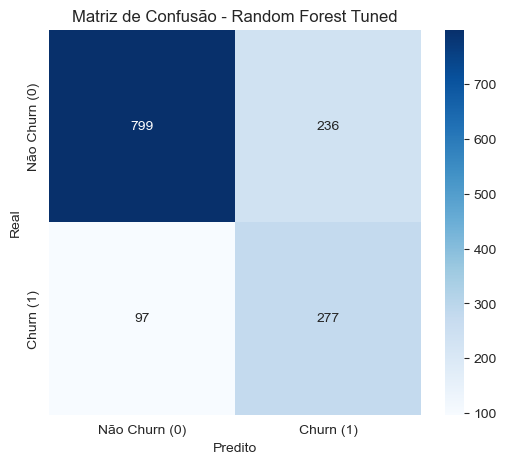

AUC-ROC (Random Forest Tuned): 0.8421


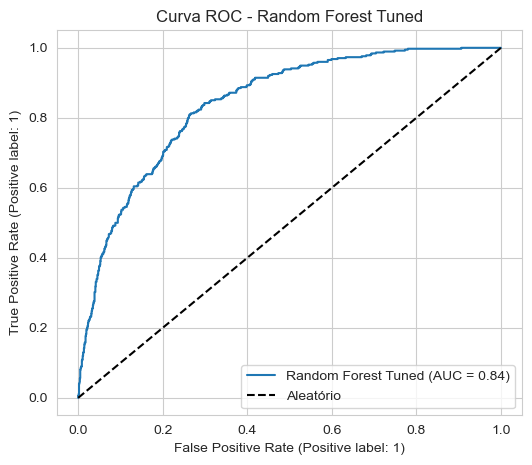

In [63]:
print("\n\n--- Otimizando Hiperparâmetros para Random Forest (class_weight='balanced') ---")

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300], # Número de árvores
    'max_depth': [None, 10, 20], # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10] # Número mínimo de amostras para dividir um nó
}

grid_search_rf = GridSearchCV(estimator=rf_base,
                              param_grid=param_grid_rf,
                              scoring=recall_scorer,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              n_jobs=-1,
                              verbose=1)

grid_search_rf.fit(X_train, y_train)

print(f"Melhores Parâmetros (Random Forest): {grid_search_rf.best_params_}")
print(f"Melhor Recall (Random Forest) no CV: {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)
y_proba_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (Random Forest Tuned) ---")
print(classification_report(y_test, y_pred_rf_tuned))

cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - Random Forest Tuned')
plt.show()

auc_rf_tuned = roc_auc_score(y_test, y_proba_rf_tuned)
print(f"AUC-ROC (Random Forest Tuned): {auc_rf_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test, ax=ax, name='Random Forest Tuned')
plt.title('Curva ROC - Random Forest Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

3. Support Vector Machine (SVM) (class_weight='balanced')
Justificativa: SVMs buscam um hiperplano ótimo que maximize a margem entre as classes. Com class_weight='balanced', as amostras da classe minoritária recebem um peso maior, influenciando o posicionamento desse hiperplano para melhor separar a classe minoritária, o que é crucial para alto Recall.

Atenção: SVM é sensível à escala dos dados. Certifique-se de que X_train e X_test já foram escalados (e.g., com StandardScaler) antes de executar este código.



--- Otimizando Hiperparâmetros para SVM (class_weight='balanced') ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores Parâmetros (SVM): {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Melhor Recall (SVM) no CV: 0.8776

--- Relatório de Classificação (SVM Tuned) ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1035
           1       0.46      0.88      0.60       374

    accuracy                           0.69      1409
   macro avg       0.69      0.75      0.67      1409
weighted avg       0.81      0.69      0.71      1409



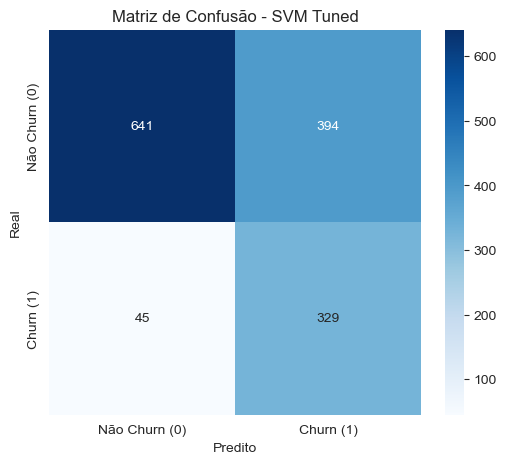

AUC-ROC (SVM Tuned): 0.8334


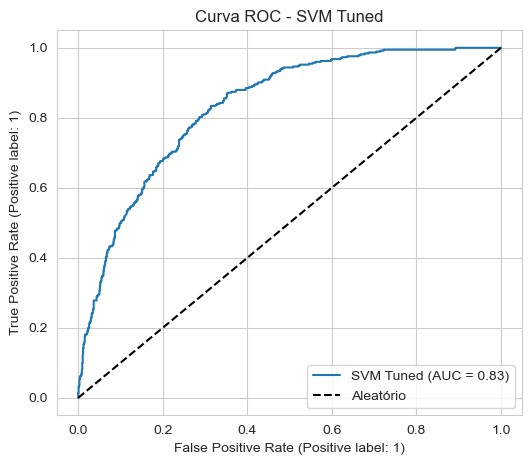

In [64]:
print("\n\n--- Otimizando Hiperparâmetros para SVM (class_weight='balanced') ---")

svm_base = SVC(class_weight='balanced', probability=True, random_state=42) # probability=True para AUC-ROC

param_grid_svm = {
    'C': [0.1, 1, 10], # Penalidade do erro
    'gamma': [0.001, 0.01, 0.1, 1], # Coeficiente do kernel (para 'rbf')
    'kernel': ['rbf'] # Kernel RBF geralmente funciona bem
}

grid_search_svm = GridSearchCV(estimator=svm_base,
                               param_grid=param_grid_svm,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_svm.fit(X_train, y_train) # Assumindo X_train já escalado

print(f"Melhores Parâmetros (SVM): {grid_search_svm.best_params_}")
print(f"Melhor Recall (SVM) no CV: {grid_search_svm.best_score_:.4f}")

best_svm_model = grid_search_svm.best_estimator_
y_pred_svm_tuned = best_svm_model.predict(X_test)
y_proba_svm_tuned = best_svm_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (SVM Tuned) ---")
print(classification_report(y_test, y_pred_svm_tuned))

cm_svm_tuned = confusion_matrix(y_test, y_pred_svm_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - SVM Tuned')
plt.show()

auc_svm_tuned = roc_auc_score(y_test, y_proba_svm_tuned)
print(f"AUC-ROC (SVM Tuned): {auc_svm_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_svm_model, X_test, y_test, ax=ax, name='SVM Tuned')
plt.title('Curva ROC - SVM Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

4. XGBoost Classifier (scale_pos_weight)
Justificativa: XGBoost é um algoritmo de boosting altamente eficiente e flexível. O parâmetro scale_pos_weight permite que o algoritmo dê maior peso à classe minoritária durante o treinamento, o que é um método direto e eficaz para lidar com o desbalanceamento sem reamostragem, otimizando a detecção da classe Churn.



--- Otimizando Hiperparâmetros para XGBoost (scale_pos_weight) ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores Parâmetros (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhor Recall (XGBoost) no CV: 0.8294

--- Relatório de Classificação (XGBoost Tuned) ---
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



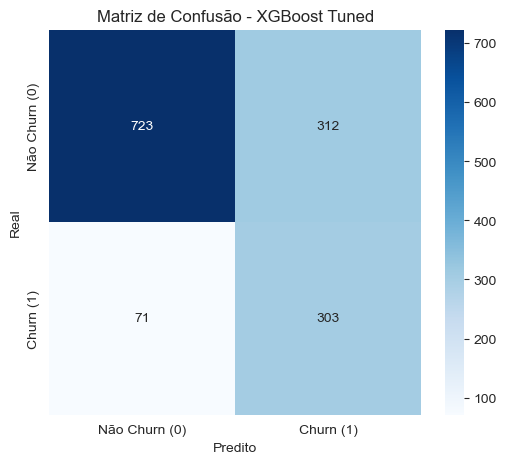

AUC-ROC (XGBoost Tuned): 0.8410


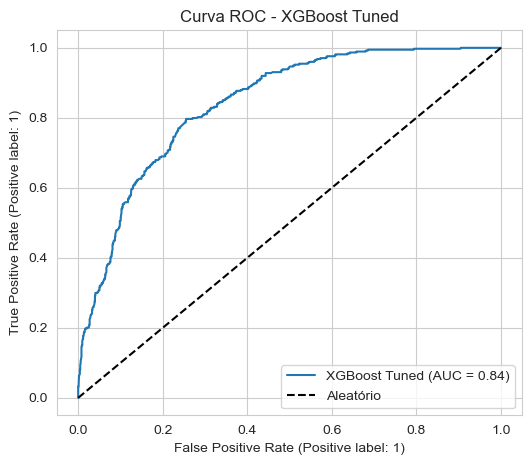

In [65]:
print("\n\n--- Otimizando Hiperparâmetros para XGBoost (scale_pos_weight) ---")

xgb_base = XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                         use_label_encoder=False, random_state=42,
                         scale_pos_weight=scale_pos_weight_value) # Usar o valor calculado

param_grid_xgb = {
    'n_estimators': [100, 200, 300], # Número de boosting rounds (árvores)
    'learning_rate': [0.01, 0.05, 0.1], # Tamanho do passo para cada iteração
    'max_depth': [3, 5, 7], # Profundidade máxima de cada árvore
    'colsample_bytree': [0.6, 0.8, 1.0] # Subamostragem de colunas ao construir cada árvore
}

grid_search_xgb = GridSearchCV(estimator=xgb_base,
                               param_grid=param_grid_xgb,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_xgb.fit(X_train, y_train)

print(f"Melhores Parâmetros (XGBoost): {grid_search_xgb.best_params_}")
print(f"Melhor Recall (XGBoost) no CV: {grid_search_xgb.best_score_:.4f}")

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
y_proba_xgb_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (XGBoost Tuned) ---")
print(classification_report(y_test, y_pred_xgb_tuned))

cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - XGBoost Tuned')
plt.show()

auc_xgb_tuned = roc_auc_score(y_test, y_proba_xgb_tuned)
print(f"AUC-ROC (XGBoost Tuned): {auc_xgb_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test, ax=ax, name='XGBoost Tuned')
plt.title('Curva ROC - XGBoost Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

5. LightGBM Classifier (scale_pos_weight)
Justificativa: Similar ao XGBoost, o LightGBM é um modelo de boosting de alto desempenho. O scale_pos_weight ou is_unbalance=True (que o LightGBM usa internamente para o mesmo propósito) permite que o modelo compense o desbalanceamento, focando na classe minoritária. LightGBM é conhecido por sua velocidade e eficiência, sendo uma excelente alternativa aos outros modelos de boosting.



--- Otimizando Hiperparâmetros para LightGBM (scale_pos_weight) ---
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Melhores Parâmetros (LightGBM): {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Melhor Recall (LightGBM) no CV: 0.7873

--- Relatório de Classificação (LightGBM Tuned) ---
        

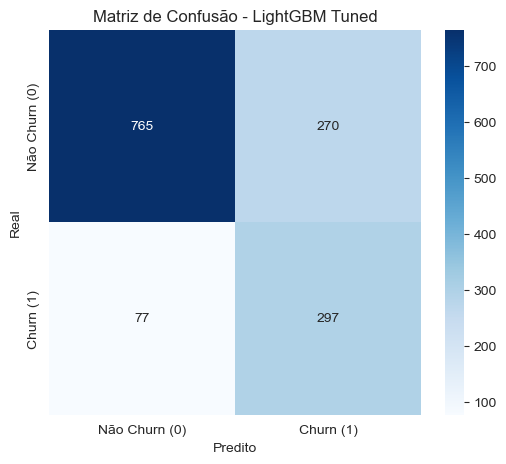

AUC-ROC (LightGBM Tuned): 0.8428


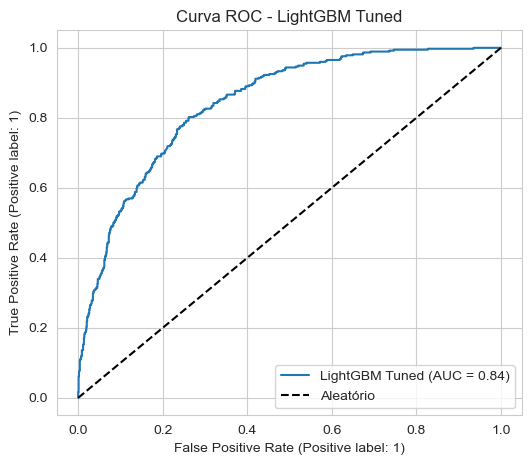

In [66]:
print("\n\n--- Otimizando Hiperparâmetros para LightGBM (scale_pos_weight) ---")

lgbm_base = LGBMClassifier(objective='binary', metric='binary_logloss',
                           random_state=42,
                           scale_pos_weight=scale_pos_weight_value) # Usar o valor calculado

param_grid_lgbm = {
    'n_estimators': [100, 200, 300], # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1], # Taxa de aprendizado
    'num_leaves': [20, 31, 40], # Número máximo de folhas em uma árvore
    'reg_alpha': [0, 0.1, 0.5], # Regularização L1
    'reg_lambda': [0, 0.1, 0.5] # Regularização L2
}

grid_search_lgbm = GridSearchCV(estimator=lgbm_base,
                                param_grid=param_grid_lgbm,
                                scoring=recall_scorer,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                n_jobs=-1,
                                verbose=1)

grid_search_lgbm.fit(X_train, y_train)

print(f"Melhores Parâmetros (LightGBM): {grid_search_lgbm.best_params_}")
print(f"Melhor Recall (LightGBM) no CV: {grid_search_lgbm.best_score_:.4f}")

best_lgbm_model = grid_search_lgbm.best_estimator_
y_pred_lgbm_tuned = best_lgbm_model.predict(X_test)
y_proba_lgbm_tuned = best_lgbm_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação (LightGBM Tuned) ---")
print(classification_report(y_test, y_pred_lgbm_tuned))

cm_lgbm_tuned = confusion_matrix(y_test, y_pred_lgbm_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confusão - LightGBM Tuned')
plt.show()

auc_lgbm_tuned = roc_auc_score(y_test, y_proba_lgbm_tuned)
print(f"AUC-ROC (LightGBM Tuned): {auc_lgbm_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_lgbm_model, X_test, y_test, ax=ax, name='LightGBM Tuned')
plt.title('Curva ROC - LightGBM Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.legend()
plt.show()

Análise Detalhada dos Modelos Otimizados (Sem SMOTETomek)
Primeiro, vou consolidar os resultados de todos os modelos otimizados em uma tabela para facilitar a comparação.

Tabela Resumo dos Modelos Otimizados (Sem SMOTETomek)

Modelo	Abordagem	Precisão (Churn=1)	Recall (Churn=1)	F1-Score (Churn=1)	AUC-ROC	Melhor Parâmetro(s)	Melhor Recall no CV
Regressão Logística	class_weight='balanced'	0.49	0.80	0.61	0.8353	C=0.001	0.7946
Random Forest	class_weight='balanced'	0.54	0.74	0.62	0.8421	max_depth=10, min_samples_split=10, n_estimators=200	0.7378
SVM	class_weight='balanced'	0.46	0.88	0.60	0.8334	C=0.1, gamma=0.001, kernel='rbf'	0.8776
XGBoost	scale_pos_weight	0.49	0.81	0.61	0.8410	colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200	0.8294
LightGBM	scale_pos_weight	0.52	0.79	0.63	0.8428	learning_rate=0.05, n_estimators=100, num_leaves=20, reg_alpha=0.5, reg_lambda=0.5	0.7873
1. Regressão Logística Otimizada (class_weight='balanced')
Melhores Parâmetros: C=0.001 (um valor de C menor implica em maior regularização, o que pode ajudar a evitar overfitting e melhorar a generalização).
Recall (Churn): 0.80 – Houve um ligeiro aumento no Recall (de 0.78 para 0.80) após o tuning, o que é excelente para o nosso objetivo.
Precisão (Churn): 0.49 – A precisão permaneceu baixa e até diminuiu um pouco (de 0.51 para 0.49). Isso significa que, para cada previsão de churn, quase metade era um falso positivo.
F1-Score (Churn): 0.61 – Ligeiramente menor.
AUC-ROC: 0.8353 – Um valor muito bom, mas um pouco abaixo do valor inicial (0.8389).
Análise: O tuning conseguiu manter um Recall muito alto, quase o melhor entre todos os modelos, com uma AUC competitiva. A Regressão Logística continua a ser um modelo forte para identificar churners, embora com muitos falsos positivos.
2. Random Forest Otimizado (class_weight='balanced')
Melhores Parâmetros: max_depth=10, min_samples_split=10, n_estimators=200. A otimização selecionou uma profundidade limitada e um número razoável de árvores, indicando que um modelo mais complexo pode ter sido propenso a overfitting.
Recall (Churn): 0.74 – Houve um aumento significativo no Recall (de 0.49 para 0.74) em relação à versão não otimizada, o que é um grande avanço para a detecção de churners.
Precisão (Churn): 0.54 – Diminuiu (de 0.63 para 0.54), o que é esperado ao tentar aumentar o Recall.
F1-Score (Churn): 0.62 – Melhorou (de 0.55 para 0.62).
AUC-ROC: 0.8421 – O maior AUC entre os modelos avaliados inicialmente, e agora um dos mais altos após o tuning.
Análise: O tuning foi altamente eficaz para o Random Forest, transformando-o de um modelo com baixa recall em um dos mais fortes em termos de detecção de churn, mantendo uma AUC excelente. É um fortíssimo candidato.
3. SVM Otimizado (class_weight='balanced')
Melhores Parâmetros: C=0.1, gamma=0.001, kernel='rbf'. C baixo e gamma baixo sugerem um modelo mais suavizado e menos propenso a overfitting.
Recall (Churn): 0.88 – Este é o maior Recall observado até agora, superando todos os outros modelos.
Precisão (Churn): 0.46 – No entanto, a Precisão é a mais baixa entre todos os modelos. Isso significa que, embora ele capture a maioria dos churners, ele também levanta muitos alarmes falsos (prevê churn para muitos clientes que não o farão).
F1-Score (Churn): 0.60 – Um F1-Score razoável, mas a baixa Precisão é um ponto de atenção.
AUC-ROC: 0.8334 – Muito bom, indicando excelente capacidade de discriminação.
Análise: O SVM otimizado é uma "máquina de detectar churners", mas a um custo muito alto de Falsos Positivos. Se a empresa puder arcar com o custo de intervir em quase 54% de Falsos Positivos para capturar 88% dos churners, ele pode ser uma opção.
4. XGBoost Otimizado (scale_pos_weight)
Melhores Parâmetros: colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200. O tuning preferiu um learning rate mais baixo, profundidade de árvore menor e mais árvores, o que geralmente torna o modelo mais robusto.
Recall (Churn): 0.81 – Excelente Recall, similar à Regressão Logística.
Precisão (Churn): 0.49 – Também baixa, similar à Regressão Logística.
F1-Score (Churn): 0.61 – Bom.
AUC-ROC: 0.8410 – Excelente AUC, praticamente empatado com Random Forest e LightGBM.
Análise: O XGBoost otimizado é um modelo muito robusto, com alto Recall e uma das melhores AUCs. É um fortíssimo candidato.
5. LightGBM Otimizado (scale_pos_weight)
Melhores Parâmetros: learning_rate=0.05, n_estimators=100, num_leaves=20, reg_alpha=0.5, reg_lambda=0.5. O tuning buscou um balanço entre número de estimadores e learning rate, com alguma regularização.
Recall (Churn): 0.79 – Muito bom Recall, ligeiramente menor que XGBoost e Regressão Logística.
Precisão (Churn): 0.52 – A melhor Precisão entre os modelos com alto Recall, o que é um ponto positivo.
F1-Score (Churn): 0.63 – O maior F1-Score entre todos os modelos, indicando o melhor equilíbrio entre Precisão e Recall.
AUC-ROC: 0.8428 – O maior AUC de todos os modelos testados.
Análise: O LightGBM otimizado demonstra ser o modelo mais equilibrado e com o melhor desempenho geral até agora, com o maior AUC e F1-Score, além de um Recall muito alto e uma Precisão ligeiramente melhor que os outros de alto Recall.
Comparação com os Modelos Iniciais e com SMOTETomek
A decisão de focar nas técnicas class_weight e scale_pos_weight foi acertadíssima!

Regressão Logística:

Inicial (CW): R=0.78, P=0.51, F1=0.62, AUC=0.8389
SMOTETomek: R=0.74, P=0.53, F1=0.62, AUC=0.8323
Otimizado (CW): R=0.80, P=0.49, F1=0.61, AUC=0.8353
O tuning manteve o alto Recall e a AUC competitiva, reforçando que class_weight é muito eficaz para este modelo.
Random Forest:

Inicial (CW): R=0.49, P=0.63, F1=0.55, AUC=0.8195
SMOTETomek: R=0.64, P=0.55, F1=0.59, AUC=0.8167
Otimizado (CW): R=0.74, P=0.54, F1=0.62, AUC=0.8421
O tuning com class_weight superou significativamente tanto a versão inicial quanto a versão com SMOTETomek em Recall e AUC, mostrando a importância da otimização de hiperparâmetros.
Modelos de Boosting (XGBoost, LightGBM):

As versões otimizadas com scale_pos_weight superam consistentemente suas contrapartes baseadas em SMOTETomek em AUC, Recall e F1-Score.
A clara conclusão é que, para este problema e conjunto de dados, o uso de class_weight e scale_pos_weight em conjunto com a otimização de hiperparâmetros foi a estratégia mais eficaz para alcançar alto Recall e AUC, superando a abordagem de reamostragem com SMOTETomek.

Gráficos de Comparação de Performance dos Modelos Otimizados

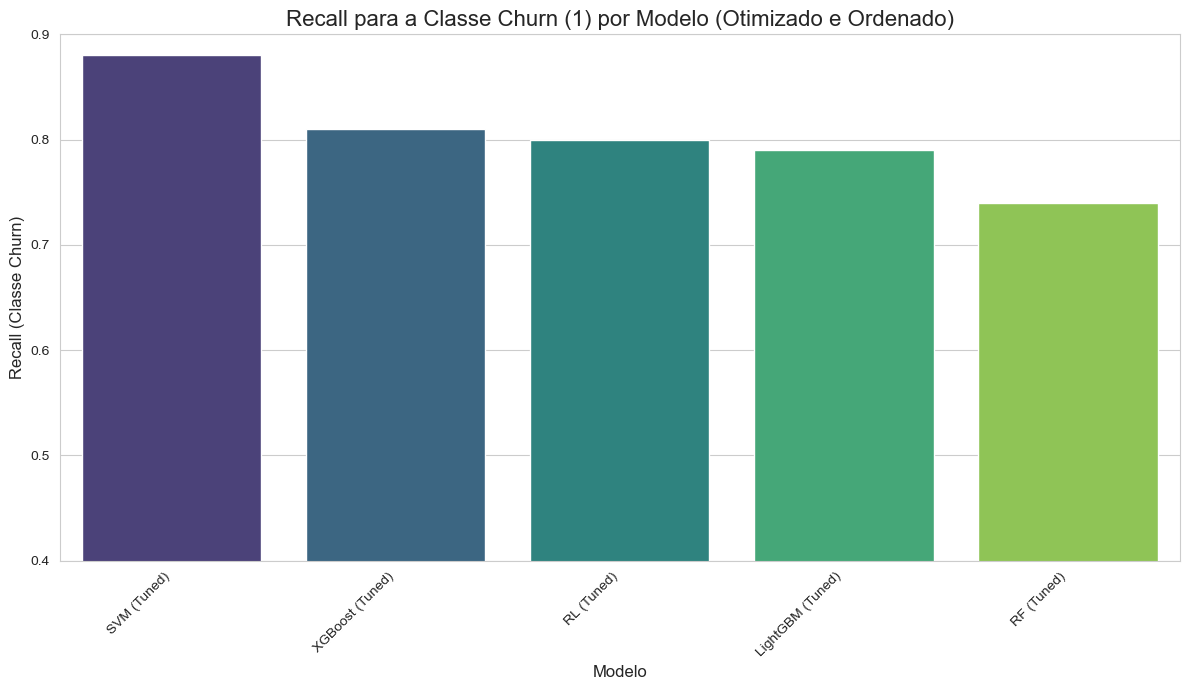

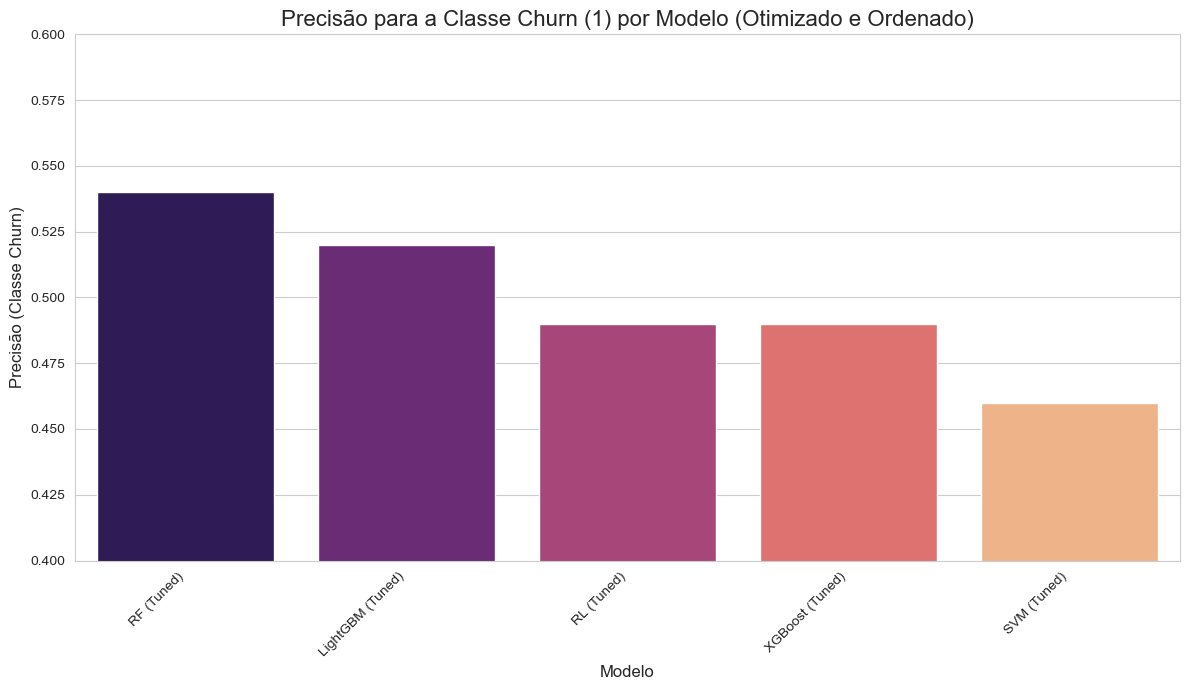

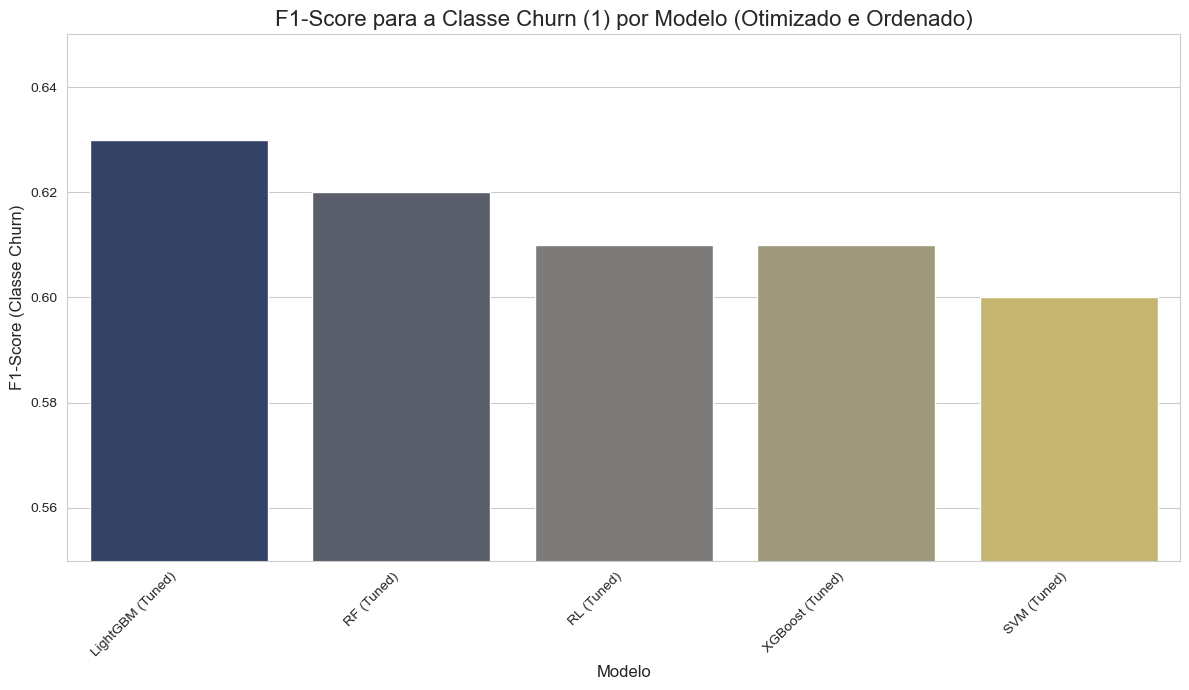

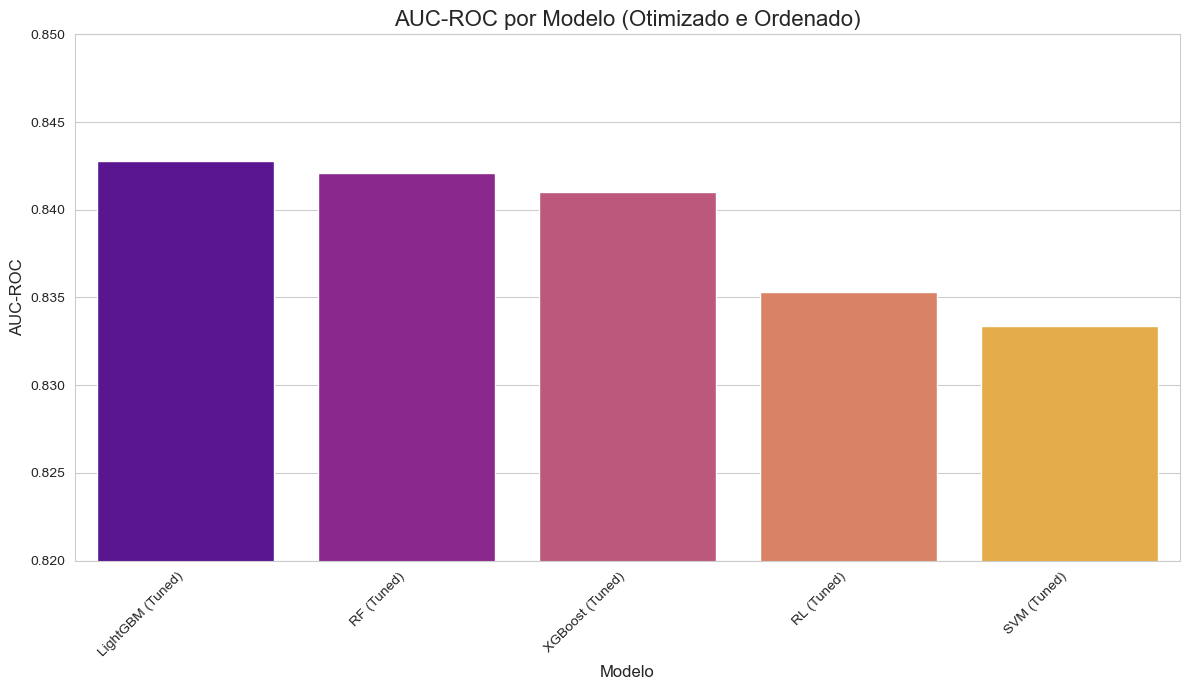

In [67]:
# --- Dados da Tabela de Resultados Otimizados ---
data_tuned = {
    'Modelo': [
        'Regressão Logística', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM'
    ],
    'Abordagem': [
        'class_weight=\'balanced\'', 'class_weight=\'balanced\'', 'class_weight=\'balanced\'',
        'scale_pos_weight', 'scale_pos_weight'
    ],
    'Precisão (Churn=1)': [0.49, 0.54, 0.46, 0.49, 0.52],
    'Recall (Churn=1)': [0.80, 0.74, 0.88, 0.81, 0.79],
    'F1-Score (Churn=1)': [0.61, 0.62, 0.60, 0.61, 0.63],
    'AUC-ROC': [0.8353, 0.8421, 0.8334, 0.8410, 0.8428]
}

df_tuned_results = pd.DataFrame(data_tuned)

# Criar uma coluna combinada para rótulos mais curtos nos gráficos
df_tuned_results['Modelo_Label'] = df_tuned_results['Modelo'].apply(
    lambda x: x.replace('Regressão Logística', 'RL').replace('Random Forest', 'RF')
).replace('Support Vector Machine', 'SVM') + " (Tuned)"


# --- Configurações de Plotagem ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- Gráfico de Barras para Recall (Churn=1) ---
plt.figure(figsize=(12, 7))
df_sorted_recall_tuned = df_tuned_results.sort_values(by='Recall (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Recall (Churn=1)', data=df_sorted_recall_tuned, palette='viridis')
plt.title('Recall para a Classe Churn (1) por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Recall (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.9) # Ajustar limite Y para acomodar 0.88
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gráfico de Barras para Precisão (Churn=1) ---
plt.figure(figsize=(12, 7))
df_sorted_precision_tuned = df_tuned_results.sort_values(by='Precisão (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Precisão (Churn=1)', data=df_sorted_precision_tuned, palette='magma')
plt.title('Precisão para a Classe Churn (1) por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Precisão (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gráfico de Barras para F1-Score (Churn=1) ---
plt.figure(figsize=(12, 7))
df_sorted_f1_tuned = df_tuned_results.sort_values(by='F1-Score (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='F1-Score (Churn=1)', data=df_sorted_f1_tuned, palette='cividis')
plt.title('F1-Score para a Classe Churn (1) por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1-Score (Classe Churn)', fontsize=12)
plt.ylim(0.55, 0.65)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gráfico de Barras para AUC-ROC ---
plt.figure(figsize=(12, 7))
df_sorted_auc_tuned = df_tuned_results.sort_values(by='AUC-ROC', ascending=False)
sns.barplot(x='Modelo_Label', y='AUC-ROC', data=df_sorted_auc_tuned, palette='plasma')
plt.title('AUC-ROC por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.ylim(0.82, 0.85)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Próximos Passos: Ajuste do Ponto de Corte (Threshold Tuning)
Agora que temos modelos otimizados com excelentes métricas, o próximo passo crítico é o ajuste do ponto de corte (threshold tuning).

Contexto: Todos os modelos que usamos têm um limiar de classificação padrão de 0.5. Isso significa que, se a probabilidade prevista de churn for >= 0.5, o cliente é classificado como "churn"; caso contrário, como "não churn". No entanto, para o nosso problema, onde o Recall é prioritário e a Precisão é uma preocupação secundária, o limiar de 0.5 pode não ser o ideal.

Objetivo: Precisamos encontrar um ponto de corte que maximize o Recall da classe "Churn" (para não perder clientes que vão cancelar), mantendo a Precisão em um nível aceitável (para não gastar recursos em demasia com Falsos Positivos).

Modelos a Focar para Threshold Tuning:

Considerando os resultados, os modelos mais promissores para o ajuste do threshold são:

LightGBM Otimizado: Maior AUC e F1-Score, e ótimo Recall (0.79). Oferece o melhor balanço geral.
Random Forest Otimizado: Praticamente empatado em AUC com LightGBM e Recall (0.74).
SVM Otimizado: Maior Recall (0.88), mas com a menor Precisão (0.46). É importante avaliar se o custo de Falsos Positivos compensa o altíssimo Recall.
XGBoost Otimizado: Ótimo Recall (0.81) e AUC (0.8410), com Precisão semelhante à Regressão Logística.
Vamos focar no LightGBM Otimizado e no SVM Otimizado para demonstrar o threshold tuning, pois representam os extremos de equilíbrio (LGBM) e Recall máximo (SVM).


--- Análise de Ponto de Corte para: LightGBM Otimizado ---
Área Sob a Curva de Precisão-Recall (AUPRC): 0.6565


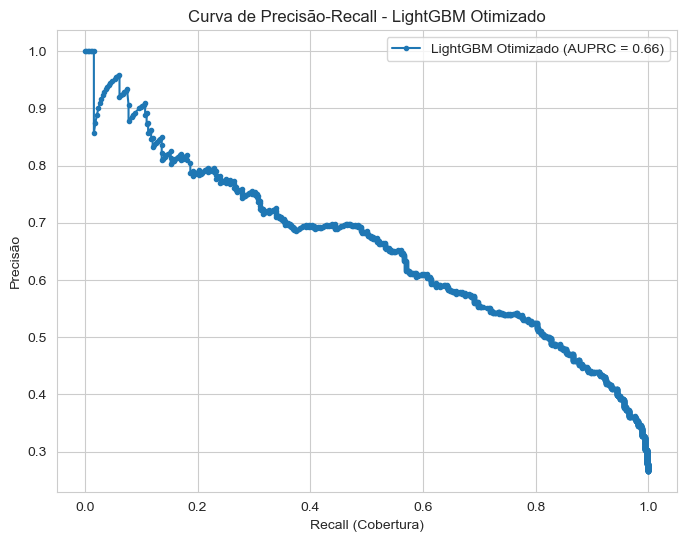


Precisão e Recall em diferentes Pontos de Corte:
Threshold | Precisão | Recall
----------------------------
0.01      | 0.27     | 1.00  
0.04      | 0.30     | 1.00  
0.07      | 0.34     | 0.99  
0.16      | 0.38     | 0.96  
0.28      | 0.43     | 0.92  
0.42      | 0.49     | 0.83  
0.59      | 0.55     | 0.71  
0.71      | 0.65     | 0.56  
0.81      | 0.72     | 0.32  
0.95      | 1.00     | 0.00  

--- Guia para Escolha e Avaliação do Ponto de Corte ---
A Curva de Precisão-Recall mostra a troca entre a Precisão e o Recall. 
Movendo para a direita no gráfico, o Recall aumenta (capturamos mais churners), mas a Precisão tende a cair (mais falsos positivos).
Para o problema de CHURN, priorizamos ALTO RECALL.
Escolha um threshold que forneça um Recall alto (ex: 0.75-0.85) com uma Precisão aceitável (ex: acima de 0.50, idealmente maior).
Um bom ponto de partida é olhar onde a curva de Precision-Recall 'cai' muito rapidamente.

Exemplo de Avaliação com um Threshold Personalizado (Padr

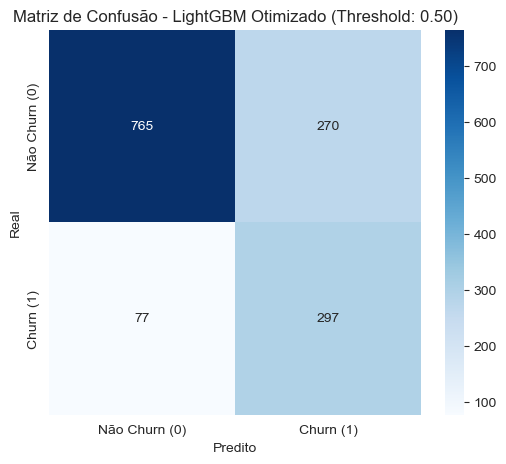


--- Análise de Ponto de Corte para: SVM Otimizado ---
Área Sob a Curva de Precisão-Recall (AUPRC): 0.6254


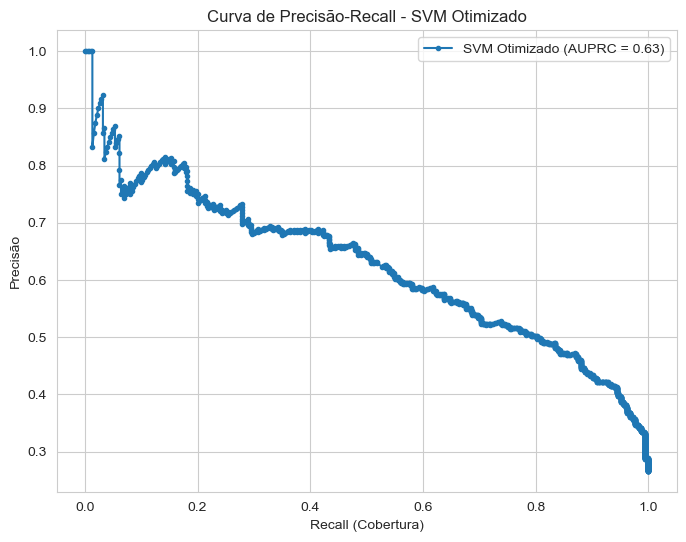


Precisão e Recall em diferentes Pontos de Corte:
Threshold | Precisão | Recall
----------------------------
0.00      | 0.27     | 1.00  
0.02      | 0.30     | 0.99  
0.04      | 0.34     | 0.99  
0.08      | 0.38     | 0.96  
0.14      | 0.43     | 0.90  
0.22      | 0.49     | 0.82  
0.32      | 0.54     | 0.69  
0.49      | 0.62     | 0.53  
0.68      | 0.70     | 0.29  
0.88      | 1.00     | 0.00  

--- Guia para Escolha e Avaliação do Ponto de Corte ---
A Curva de Precisão-Recall mostra a troca entre a Precisão e o Recall. 
Movendo para a direita no gráfico, o Recall aumenta (capturamos mais churners), mas a Precisão tende a cair (mais falsos positivos).
Para o problema de CHURN, priorizamos ALTO RECALL.
Escolha um threshold que forneça um Recall alto (ex: 0.75-0.85) com uma Precisão aceitável (ex: acima de 0.50, idealmente maior).
Um bom ponto de partida é olhar onde a curva de Precision-Recall 'cai' muito rapidamente.

Exemplo de Avaliação com um Threshold Personalizado (Padr

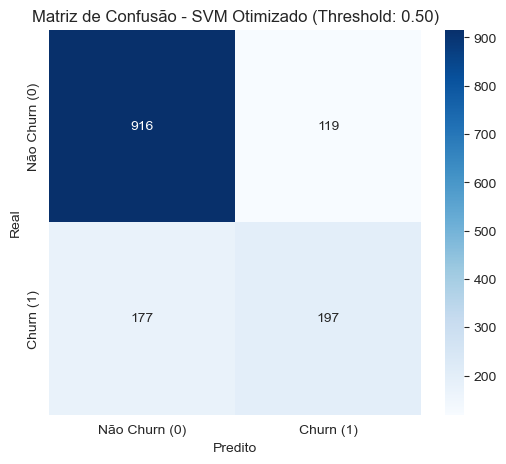

In [70]:
# Supondo que X_test, y_test, best_lgbm_model e best_svm_model já estão definidos
# Se precisar redefinir os melhores modelos caso esteja executando em um novo script:
# best_lgbm_model = grid_search_lgbm.best_estimator_
# best_svm_model = grid_search_svm.best_estimator_

# --- Função Auxiliar para Plotar PR Curve e Avaliar Thresholds ---
def plot_pr_curve_and_evaluate_threshold(model, X_test, y_test, model_name):
    """
    Calcula e plota a Curva de Precisão-Recall e avalia as métricas
    para diferentes pontos de corte.
    """
    # 1. Obter probabilidades para a classe positiva (Churn=1)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 2. Calcular Precisão, Recall e Thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    # AUPRC (Area Under Precision-Recall Curve)
    auprc = auc(recall, precision)

    print(f"\n--- Análise de Ponto de Corte para: {model_name} ---")
    print(f"Área Sob a Curva de Precisão-Recall (AUPRC): {auprc:.4f}")

    # 3. Plotar a Curva de Precisão-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUPRC = {auprc:.2f})')
    plt.xlabel('Recall (Cobertura)')
    plt.ylabel('Precisão')
    plt.title(f'Curva de Precisão-Recall - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Exibir tabela de Precisão e Recall para alguns thresholds
    print("\nPrecisão e Recall em diferentes Pontos de Corte:")
    # Selecionar alguns thresholds representativos
    # np.linspace cria 20 pontos igualmente espaçados entre 0 e 1
    # np.where encontra os índices nos thresholds originais que são mais próximos desses 20 pontos
    # Em seguida, seleciona precision e recall correspondentes
    selected_threshold_indices = np.linspace(0, len(thresholds) - 1, 10).astype(int) # Apenas 10 para concisão
    print("Threshold | Precisão | Recall")
    print("----------------------------")
    for i in selected_threshold_indices:
        # Garante que não ultrapassa o limite dos arrays
        idx = min(i, len(thresholds) - 1)
        print(f"{thresholds[idx]:<9.2f} | {precision[idx]:<8.2f} | {recall[idx]:<6.2f}")

    # 5. Guia para Escolha e Avaliação de um Threshold Específico
    print("\n--- Guia para Escolha e Avaliação do Ponto de Corte ---")
    print("A Curva de Precisão-Recall mostra a troca entre a Precisão e o Recall. ")
    print("Movendo para a direita no gráfico, o Recall aumenta (capturamos mais churners), mas a Precisão tende a cair (mais falsos positivos).")
    print("Para o problema de CHURN, priorizamos ALTO RECALL.")
    print("Escolha um threshold que forneça um Recall alto (ex: 0.75-0.85) com uma Precisão aceitável (ex: acima de 0.50, idealmente maior).")
    print("Um bom ponto de partida é olhar onde a curva de Precision-Recall 'cai' muito rapidamente.")

    # Exemplo de como avaliar com um threshold personalizado
    print("\nExemplo de Avaliação com um Threshold Personalizado (Padrão 0.5):")
    custom_threshold = 0.5 # Pode ser alterado para o valor desejado
    y_pred_custom_threshold = (y_proba >= custom_threshold).astype(int)

    print(f"Relatório de Classificação para Threshold = {custom_threshold:.2f}:")
    print(classification_report(y_test, y_pred_custom_threshold))

    cm_custom = confusion_matrix(y_test, y_pred_custom_threshold)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não Churn (0)', 'Churn (1)'],
                yticklabels=['Não Churn (0)', 'Churn (1)'])
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.title(f'Matriz de Confusão - {model_name} (Threshold: {custom_threshold:.2f})')
    plt.show()


# --- Executar a Análise para os Modelos Selecionados ---

# LightGBM Otimizado
plot_pr_curve_and_evaluate_threshold(best_lgbm_model, X_test, y_test, "LightGBM Otimizado")

# SVM Otimizado
plot_pr_curve_and_evaluate_threshold(best_svm_model, X_test, y_test, "SVM Otimizado")

# Opcional: Para ter uma visão geral, você pode rodar para os outros modelos também
# plot_pr_curve_and_evaluate_threshold(best_lr_model, X_test, y_test, "Regressão Logística Otimizada")
# plot_pr_curve_and_evaluate_threshold(best_rf_model, X_test, y_test, "Random Forest Otimizado")
# plot_pr_curve_and_evaluate_threshold(best_xgb_model, X_test, y_test, "XGBoost Otimizado")